# SETUP:

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore") #optional
import pandas as pd
import statsmodels.api as sm
import matplotlib
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import scipy
import seaborn as sns
import pickle

In [2]:
sugar = pd.read_csv('Refined Sugar Master.csv', parse_dates=['date'])
sugar

,date,product_id,product,by_product_id,by_product,province_id,province,lcu_id,district_id,station_id,...,maximum,mill_id,mill_name,do_price,wholesale,retail_price,delivered,spot_price_central_punjab,spot_price_southern_punjab,spot_price_northern_punjab
0,2011-06-22,2,Sugar,17,jodia_bazaar,5,Sindh,14.0,41,277,...,NaN,NaN,NaN,65.70,66.8,NaN,NaN,NaN,NaN,NaN
1,2011-06-23,2,Sugar,17,jodia_bazaar,5,Sindh,14.0,41,277,...,NaN,NaN,NaN,65.80,66.8,NaN,NaN,NaN,NaN,NaN
2,2011-06-23,2,Sugar,17,jodia_bazaar,5,Sindh,14.0,41,277,...,NaN,NaN,NaN,66.00,66.8,NaN,NaN,NaN,NaN,NaN
3,2011-06-24,2,Sugar,17,jodia_bazaar,5,Sindh,14.0,41,277,...,NaN,NaN,NaN,66.55,66.8,NaN,NaN,NaN,NaN,NaN
4,2011-06-25,2,Sugar,17,jodia_bazaar,5,Sindh,14.0,41,277,...,NaN,NaN,NaN,66.80,66.8,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35233,2019-12-31,2,Sugar,15,mill_gate,4,Punjab,12.0,23,154,...,192.0,94.0,Tandliawala Sugar Mill,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35234,2019-12-31,2,Sugar,15,mill_gate,4,Punjab,12.0,23,538,...,192.0,109.0,Rasool Nawaz Sugar Mill,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35235,2019-12-31,2,Sugar,15,mill_gate,4,Punjab,10.0,120,571,...,192.0,89.0,Huda Sugar Mill,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35236,2019-12-31,2,Sugar,17,akbari_mandi,4,Punjab,10.0,57,661,...,NaN,NaN,NaN,NaN,71.0,NaN,NaN,70.0,67.7,NaN


In [3]:
sugar['date'] = pd.to_datetime(sugar['date'], format='%Y-%m-%d')

#Create a 'price' column by consolidating price information
def consolidate_price(row):
    if pd.notnull(row['do_price']):
        if pd.notnull(row['wholesale']):
            return (row['do_price'] + row['wholesale']) / 2
        return row['do_price']
    elif pd.notnull(row['wholesale']):
        return row['wholesale']
    elif pd.notnull(row['retail_price']):
        return row['retail_price']
    elif pd.notnull(row['minimum']) and pd.notnull(row['maximum']):
        return (row['minimum'] + row['maximum']) / 2
    elif pd.notnull(row['minimum']):
        return row['minimum']
    elif pd.notnull(row['maximum']):
        return row['maximum']
    else:
        return np.nan

sugar['price'] = sugar.apply(consolidate_price, axis=1)
sugar

,date,product_id,product,by_product_id,by_product,province_id,province,lcu_id,district_id,station_id,...,mill_id,mill_name,do_price,wholesale,retail_price,delivered,spot_price_central_punjab,spot_price_southern_punjab,spot_price_northern_punjab,price
0,2011-06-22,2,Sugar,17,jodia_bazaar,5,Sindh,14.0,41,277,...,NaN,NaN,65.70,66.8,NaN,NaN,NaN,NaN,NaN,66.250
1,2011-06-23,2,Sugar,17,jodia_bazaar,5,Sindh,14.0,41,277,...,NaN,NaN,65.80,66.8,NaN,NaN,NaN,NaN,NaN,66.300
2,2011-06-23,2,Sugar,17,jodia_bazaar,5,Sindh,14.0,41,277,...,NaN,NaN,66.00,66.8,NaN,NaN,NaN,NaN,NaN,66.400
3,2011-06-24,2,Sugar,17,jodia_bazaar,5,Sindh,14.0,41,277,...,NaN,NaN,66.55,66.8,NaN,NaN,NaN,NaN,NaN,66.675
4,2011-06-25,2,Sugar,17,jodia_bazaar,5,Sindh,14.0,41,277,...,NaN,NaN,66.80,66.8,NaN,NaN,NaN,NaN,NaN,66.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35233,2019-12-31,2,Sugar,15,mill_gate,4,Punjab,12.0,23,154,...,94.0,Tandliawala Sugar Mill,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.000
35234,2019-12-31,2,Sugar,15,mill_gate,4,Punjab,12.0,23,538,...,109.0,Rasool Nawaz Sugar Mill,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.000
35235,2019-12-31,2,Sugar,15,mill_gate,4,Punjab,10.0,120,571,...,89.0,Huda Sugar Mill,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.000
35236,2019-12-31,2,Sugar,17,akbari_mandi,4,Punjab,10.0,57,661,...,NaN,NaN,NaN,71.0,NaN,NaN,70.0,67.7,NaN,71.000


In [4]:
#Remove unnecessary columns
columns_to_keep = ['date', 'province', 'by_product', 'price', 'station']
sugar = sugar[columns_to_keep]

#Drop rows with missing price values
sugar.dropna(subset=['price'], inplace=True)

In [5]:
sugar

,date,province,by_product,price,station
0,2011-06-22,Sindh,jodia_bazaar,66.250,Karachi
1,2011-06-23,Sindh,jodia_bazaar,66.300,Karachi
2,2011-06-23,Sindh,jodia_bazaar,66.400,Karachi
3,2011-06-24,Sindh,jodia_bazaar,66.675,Karachi
4,2011-06-25,Sindh,jodia_bazaar,66.800,Karachi
...,...,...,...,...,...
35233,2019-12-31,Punjab,mill_gate,192.000,Faisalabad
35234,2019-12-31,Punjab,mill_gate,192.000,Samundari
35235,2019-12-31,Punjab,mill_gate,192.000,Sheikhupura
35236,2019-12-31,Punjab,akbari_mandi,71.000,Lahore


In [6]:
#Set 'date' as index and sort
sugar = sugar.set_index('date').sort_index()

In [7]:
sugar

,province,by_product,price,station
date,,,,
2011-06-22,Sindh,jodia_bazaar,66.250,Karachi
2011-06-23,Sindh,jodia_bazaar,66.300,Karachi
2011-06-23,Sindh,jodia_bazaar,66.400,Karachi
2011-06-24,Sindh,jodia_bazaar,66.675,Karachi
2011-06-25,Sindh,jodia_bazaar,66.800,Karachi
...,...,...,...,...
2019-12-31,Punjab,mill_gate,192.000,Faisalabad
2019-12-31,Punjab,mill_gate,192.000,Samundari
2019-12-31,Punjab,mill_gate,192.000,Sheikhupura


In [8]:
sugar.province.unique()

array(['Sindh', 'Punjab', 'KPK'], dtype=object)

# Dataframes for station and by_product:

In [9]:
#Create separate DataFrames for each station and by-product
grouped = sugar.groupby(['station', 'by_product'])

# Dictionary to hold the DataFrames
dfs = {}

for (station, by_product), daily_group in grouped:
    #Resample the data into days, taking the mean of 'price'
    daily_group = daily_group['price'].resample('D').mean()

    #Add 'station' and 'by_product' back to the DataFrame
    daily_group['station'] = station
    daily_group['by_product'] = by_product

    #Reset index to turn 'date' back into a column
    daily_group = daily_group.reset_index()

    #Split the data into training and testing sets
    split_index = int(len(daily_group) * 0.9)
    train_df = daily_group.iloc[:split_index]
    test_df = daily_group.iloc[split_index:]
    train_df.dropna(inplace=True)
    test_df.dropna(inplace=True)

    #Store the DataFrames in the dictionary
    dfs[(station, by_product)] = {
        'train': train_df,
        'test': test_df
    }

for key, datasets in dfs.items():
    station, by_product = key
    train_df = datasets['train']
    test_df = datasets['test']

    print(f"\nStation: {station}, By-Product: {by_product}")
    print(f"Training DataFrame shape: {train_df.shape}")
    print(f"Testing DataFrame shape: {test_df.shape}")


Station: Badin, By-Product: mill_gate
Training DataFrame shape: (75, 2)
Testing DataFrame shape: (4, 2)

Station: Badin, By-Product: sugar_mills
Training DataFrame shape: (244, 2)
Testing DataFrame shape: (10, 2)

Station: Bahawalnagar, By-Product: mill_gate
Training DataFrame shape: (130, 2)
Testing DataFrame shape: (24, 2)

Station: Bahawalnagar, By-Product: sugar_mills
Training DataFrame shape: (310, 2)
Testing DataFrame shape: (27, 2)

Station: Bahawalpur, By-Product: mill_gate
Training DataFrame shape: (120, 2)
Testing DataFrame shape: (24, 2)

Station: Bahawalpur, By-Product: sugar_mills
Training DataFrame shape: (510, 2)
Testing DataFrame shape: (98, 2)

Station: Chiniot, By-Product: mill_gate
Training DataFrame shape: (94, 2)
Testing DataFrame shape: (20, 2)

Station: Chiniot, By-Product: sugar_mills
Training DataFrame shape: (592, 2)
Testing DataFrame shape: (124, 2)

Station: Dadu, By-Product: mill_gate
Training DataFrame shape: (68, 2)
Testing DataFrame shape: (10, 2)

Stat

## Making provincial example df:

In [28]:
punjab_df = sugar.loc[(sugar['province'] == 'Punjab') & (sugar['by_product'] == 'akbari_mandi')].drop(['province','by_product', 'station'], axis=1)
punjab_df = punjab_df['price'].resample('D').mean()
punjab_df.dropna(inplace=True)
punjab_df

,price
date,
2011-07-11,68.50
2011-07-12,68.50
2011-07-13,68.75
2011-07-15,69.35
2011-07-18,69.75
...,...
2019-12-24,68.75
2019-12-26,70.50
2019-12-27,71.00


In [21]:
sindh_df = sugar.loc[(sugar['province'] == 'Sindh') & (sugar['by_product'] == 'jodia_bazaar')].drop(['province','by_product', 'station'], axis=1)
sindh_df = sindh_df['price'].resample('D').mean()
sindh_df.dropna(inplace=True)
sindh_df

,price
date,
2011-06-22,66.2500
2011-06-23,66.3500
2011-06-24,66.6750
2011-06-25,66.8000
2011-06-27,66.9375
...,...
2019-12-24,67.2500
2019-12-26,68.2500
2019-12-27,68.2500


In [22]:
kpk_df = sugar.loc[(sugar['province'] == 'KPK') & (sugar['by_product'] == 'sugar_mills')].drop(['province','by_product', 'station'], axis=1)
kpk_df = kpk_df['price'].resample('D').mean()
kpk_df.dropna(inplace=True)
kpk_df

,price
date,
2017-01-12,6100.0
2017-01-13,6050.0
2017-01-17,6100.0
2017-01-18,5960.0
2017-01-20,6050.0
...,...
2019-12-24,6687.5
2019-12-26,6750.0
2019-12-27,6805.0


AttributeError: 'Series' object has no attribute 'insert'

In [27]:
punjab_df

,price
date,
2011-07-11 00:00:00,68.5
2011-07-12 00:00:00,68.5
2011-07-13 00:00:00,68.75
2011-07-15 00:00:00,69.35
2011-07-18 00:00:00,69.75
...,...
2019-12-26 00:00:00,70.5
2019-12-27 00:00:00,71.0
2019-12-30 00:00:00,71.1


## Making station example df:

In [13]:
karachi_df = sugar.loc[(sugar['station'] == 'Karachi') & (sugar['by_product'] == 'jodia_bazaar')].drop(['station','by_product', 'province'], axis=1)

In [14]:
karachi_df = karachi_df['price'].resample('D').mean()
karachi_df.dropna(inplace=True)

In [15]:
karachi_df

,price
date,
2011-06-22,66.2500
2011-06-23,66.3500
2011-06-24,66.6750
2011-06-25,66.8000
2011-06-27,66.9375
...,...
2019-12-24,67.2500
2019-12-26,68.2500
2019-12-27,68.2500


In [16]:
train = karachi_df[karachi_df.index <= pd.to_datetime("2019-01-01", format='%Y-%m-%d')]
test = karachi_df[karachi_df.index >= pd.to_datetime("2019-01-01", format='%Y-%m-%d')]

In [17]:
test

,price
date,
2019-01-01,52.65
2019-01-02,52.75
2019-01-03,53.55
2019-01-04,54.75
2019-01-07,55.35
...,...
2019-12-24,67.25
2019-12-26,68.25
2019-12-27,68.25


# RANDOM FOREST

In [17]:
#extract the seasonality data
months = [x.month for x in train.index]
years = [x.year for x in train.index]
day = [x.day for x in train.index]

#convert into one matrix
trainX = np.array([day, months, years]).T
trainY = train.values

# extract the day, month and year data
tmonths = [x.month for x in test.index]
tyears = [x.year for x in test.index]
tday = [x.day for x in test.index]

# convert into one matrix
testX = np.array([tday, tmonths, tyears]).T
testY = test.values

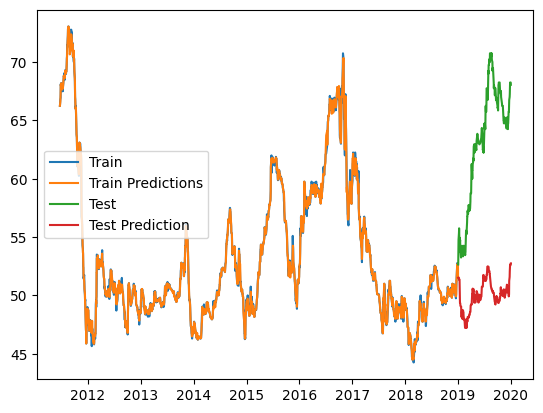

RMSE:  13.618783006609842


In [18]:
# fit the model
rfmodel = RandomForestRegressor(n_estimators=3, random_state=99)
rfmodel.fit(trainX,trainY)

# predict for the test set period
preds_train = rfmodel.predict(trainX)

# predict for the test set period
preds = rfmodel.predict(testX)

# plot what has been learned
plt.plot(train.index.values, train.values, label='Train')
plt.plot(train.index.values, preds_train, label='Train Predictions')
plt.plot(test.index.values, test.values, label='Test')
plt.plot(test.index.values, preds, label='Test Prediction')
plt.legend()
plt.show()
rf_rmse = np.sqrt(mean_squared_error(test.values, preds))
print("RMSE: ",rf_rmse)

# ARIMA:

In [19]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 31.9 MB/s eta 0:00:00


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2374.620, Time=1.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2437.269, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2381.748, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2388.408, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2435.731, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2372.799, Time=7.39 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2381.332, Time=0.87 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2371.715, Time=1.76 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2372.875, Time=3.78 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2377.124, Time=0.93 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2369.953, Time=2.26 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2386.765, Time=1.54 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2380.074, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2371.102, Time=2.07 sec
 ARIMA(1,1,2)(0,0,0)[0]          

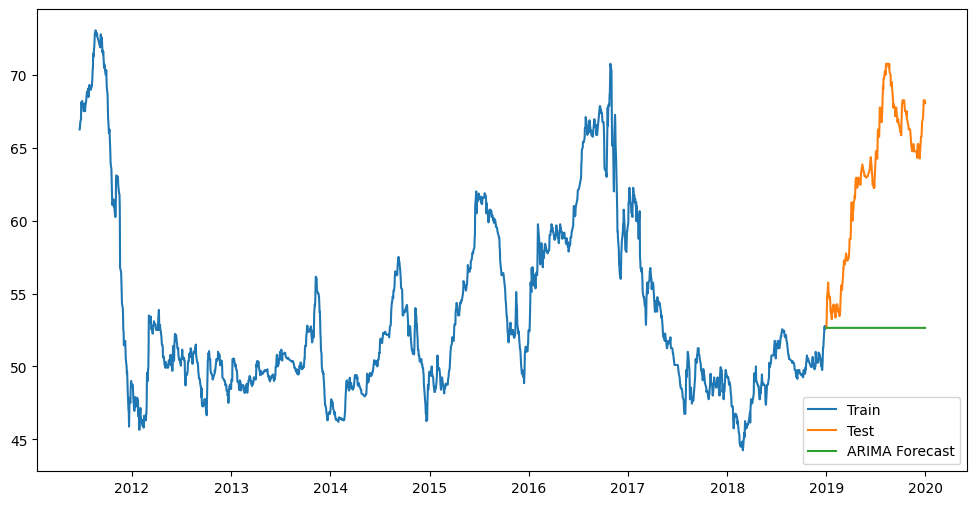

In [20]:
from pmdarima import auto_arima

stepwise_model = auto_arima(train.values, seasonal=True, trace=True)
stepwise_model.fit(train.values)

# Forecast
forecast = stepwise_model.predict(n_periods=len(test))
forecast = pd.Series(forecast, index=test.index)

# Evaluation
mse = mean_squared_error(test.values, forecast)
print(f'ARIMA MSE: {mse}')

# Plot
plt.figure(figsize=(12,6))
plt.plot(train.index.values, train.values, label='Train')
plt.plot(test.index.values, test.values, label='Test')
plt.plot(test.index.values, forecast, label='ARIMA Forecast')
plt.legend()
plt.show()

# FACEBOOK PROPHET:

In [21]:
!pip install prophet

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqufzdtkb/e5kmxg81.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqufzdtkb/pkzcv3_4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50847', 'data', 'file=/tmp/tmpqufzdtkb/e5kmxg81.json', 'init=/tmp/tmpqufzdtkb/pkzcv3_4.json', 'output', 'file=/tmp/tmpqufzdtkb/prophet_model7saxz_pk/prophet_model-20241119070127.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:01:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:01:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet MSE: 199.68322029113816


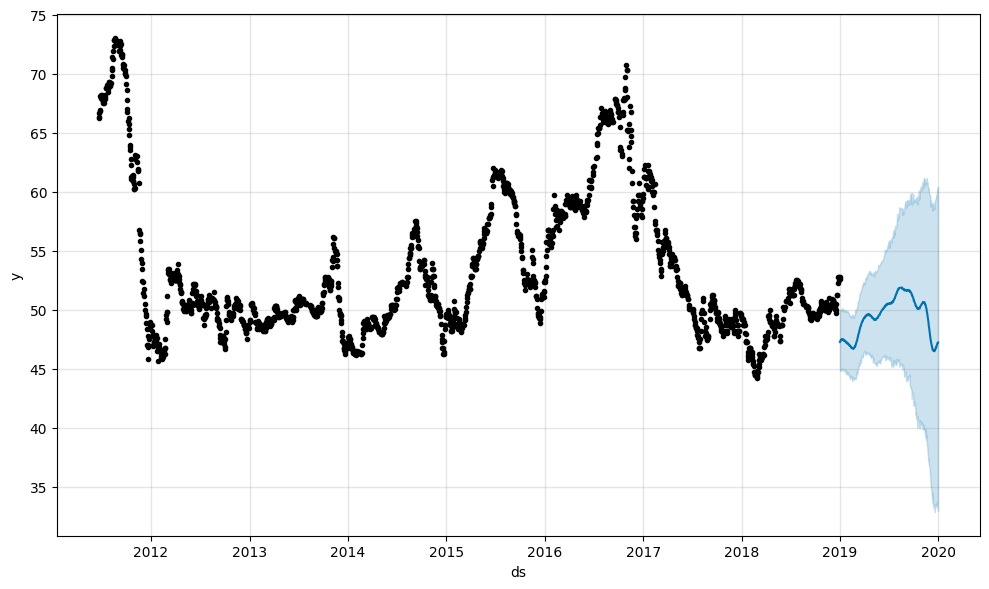

In [22]:
from prophet import Prophet

# Prepare data
train_prophet = train.reset_index().rename(columns={'date': 'ds', 'price': 'y'})
test_prophet = test.reset_index().rename(columns={'date': 'ds', 'price': 'y'})

# Initialize and fit the model
model = Prophet()
model.fit(train_prophet)

# Create future dataframe with the same dates as test data
future = pd.DataFrame({'ds': test_prophet['ds']})  # Use test dates for prediction

forecast = model.predict(future)

# Extract forecast for test period
# The index 'ds' now matches in both dataframes
forecast_test = forecast.set_index('ds').loc[test_prophet['ds']]['yhat']

# Evaluation
mse = mean_squared_error(test_prophet['y'], forecast_test)
print(f'Prophet MSE: {mse}')

# Plot
model.plot(forecast)
plt.show()

# LSTM:

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0874 - val_loss: 8.8385e-04
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0021 - val_loss: 5.4985e-04
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - val_loss: 4.4365e-04
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - val_loss: 4.2909e-04
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - val_loss: 4.1782e-04
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - val_loss: 5.6643e-04
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 - val_loss: 3.9571e-04
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.1568e-04 - val_loss: 4.6815e-04
Epoch 9/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.6305e-04 - val_loss: 4.0845e-04
Epoch 10/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.3934e-04 - val_loss: 3.4609e-04
Epoch 11/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.5048e-04 - val_loss: 3.7658e-04
Epoch 12/20
5

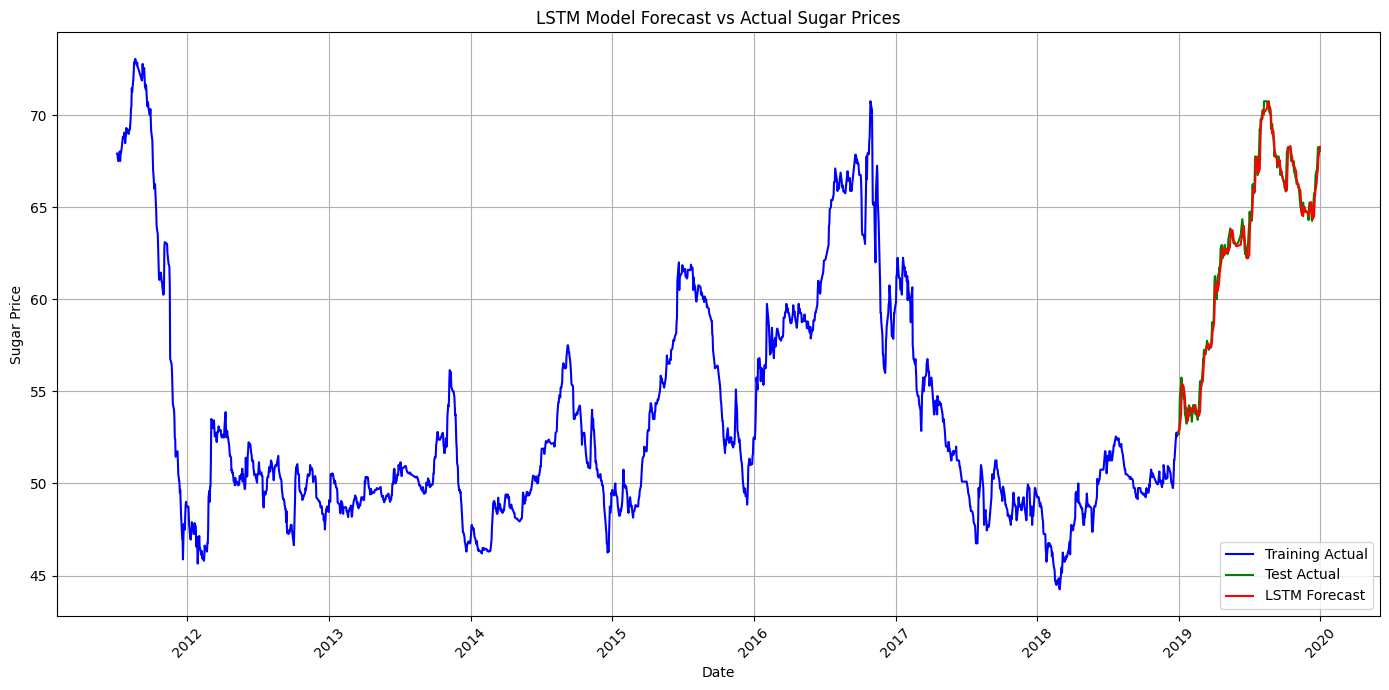

In [18]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

karachi_df = karachi_df.sort_index()

# Data Preparation
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(karachi_df.values.reshape(-1, 1))

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

SEQ_LENGTH = 10
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Train-Test Split
n = 240  # Number of test samples
X_train, X_test = X[:-n], X[-n:]
y_train, y_test = y[:-n], y[-n:]

# Reshape for LSTM [samples, time_steps, features]
X_train = X_train.reshape((X_train.shape[0], SEQ_LENGTH, 1))
X_test = X_test.reshape((X_test.shape[0], SEQ_LENGTH, 1))

# Model Building
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(SEQ_LENGTH, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Training
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# Prediction
forecast_scaled = model.predict(X_test)
forecast = scaler.inverse_transform(forecast_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluation
mse = mean_squared_error(y_test_actual, forecast)
print(f'LSTM MSE: {mse}')

# Preparing Dates for Plotting
# All dates corresponding to the sequences (excluding the first SEQ_LENGTH dates)
all_dates = karachi_df.index[SEQ_LENGTH:]

# Split dates into training and testing
train_dates = all_dates[:-n]
test_dates = all_dates[-n:]

# Inverse transform y_train for plotting
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

# Plotting
plt.figure(figsize=(14, 7))

# Plot Training Data
plt.plot(
    train_dates,
    y_train_actual,
    label='Training Actual',
    color='blue'
)

# Plot Actual Test Data
plt.plot(
    test_dates,
    y_test_actual,
    label='Test Actual',
    color='green'
)

# Plot Forecasted Data
plt.plot(
    test_dates,
    forecast,
    label='LSTM Forecast',
    color='red'
)

# Enhancements for Clarity
plt.xlabel('Date')
plt.ylabel('Sugar Price')
plt.title('LSTM Model Forecast vs Actual Sugar Prices')
plt.legend()
plt.grid(True)

# Improve Date Formatting on X-axis
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, accuracy_score

mse = mean_squared_error(y_test_actual, forecast)
mae = mean_absolute_error(y_test_actual, forecast)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test_actual, forecast)
r2 = r2_score(y_test_actual, forecast)

print(f'LSTM Evaluation Metrics:')
print(f'------------------------')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'R-squared (R²) Score: {r2:.4f}')

LSTM Evaluation Metrics:
------------------------
Mean Squared Error (MSE): 0.3398
Mean Absolute Error (MAE): 0.4306
Root Mean Squared Error (RMSE): 0.5829
Mean Absolute Percentage Error (MAPE): 0.01%
R-squared (R²) Score: 0.9875


In [25]:
output = pd.DataFrame({
    'date': test_dates,
    'predicted_price': forecast.flatten()
})

In [ ]:
output

,date,predicted_price
0,2018-12-31,52.884876
1,2019-01-01,52.992264
2,2019-01-02,52.937359
3,2019-01-03,52.904579
4,2019-01-04,53.166500
...,...,...
235,2019-12-24,66.728050
236,2019-12-26,67.014938
237,2019-12-27,67.615875
238,2019-12-30,67.951584


In [ ]:
output.to_csv('sugar_prediction.csv')

# XGBoost:

In [21]:
karachi_df = karachi_df.reset_index()

In [22]:
karachi_df['date'] = pd.to_datetime(karachi_df['date'])
# Set 'date' as the index
karachi_df.set_index('date', inplace=True)

[0]	validation_0-rmse:5.93595	validation_1-rmse:10.86314
[100]	validation_0-rmse:2.33436	validation_1-rmse:4.32100
[200]	validation_0-rmse:0.96538	validation_1-rmse:1.88458
[300]	validation_0-rmse:0.47373	validation_1-rmse:0.98507
[400]	validation_0-rmse:0.31703	validation_1-rmse:0.68119
[500]	validation_0-rmse:0.26517	validation_1-rmse:0.57584
[600]	validation_0-rmse:0.24246	validation_1-rmse:0.52885
[700]	validation_0-rmse:0.22812	validation_1-rmse:0.50810
[800]	validation_0-rmse:0.21596	validation_1-rmse:0.49791
[900]	validation_0-rmse:0.20615	validation_1-rmse:0.48994
[999]	validation_0-rmse:0.19713	validation_1-rmse:0.48472


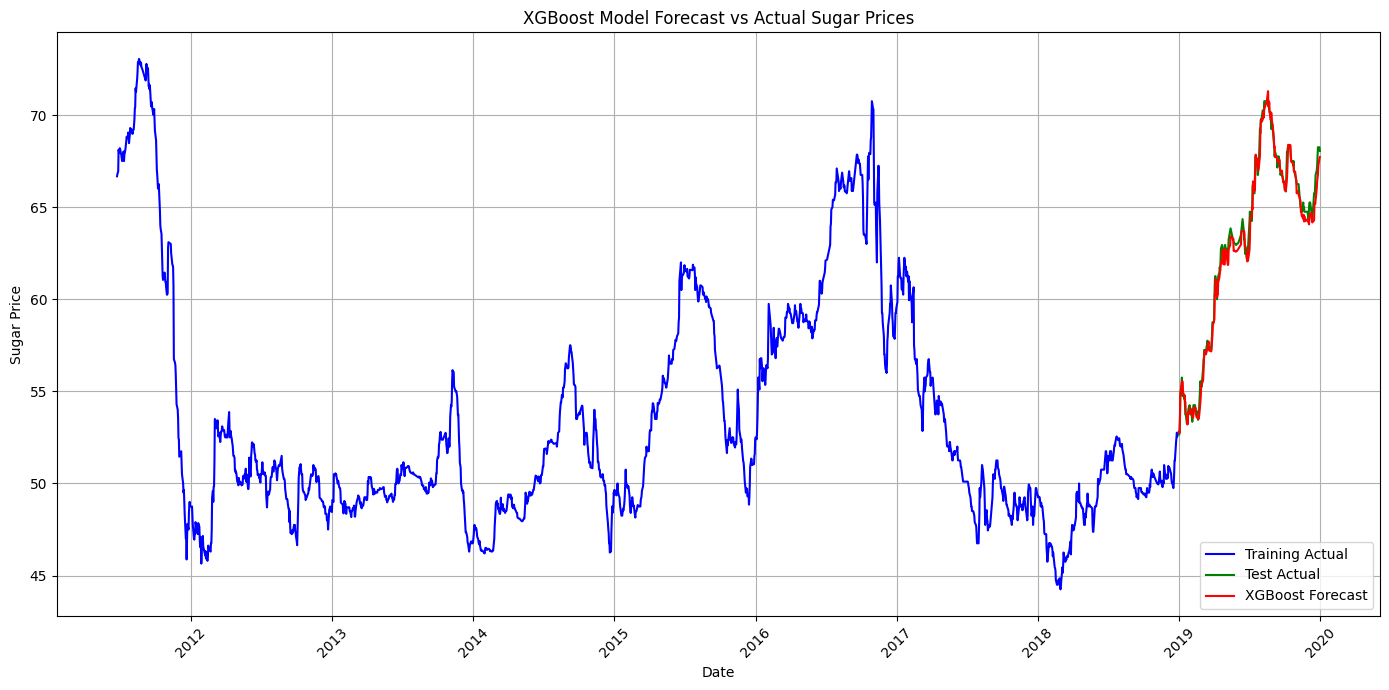

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Feature Engineering
def create_features(df, lags=5, rolling_window=3):
    df_feat = df.copy()
    for lag in range(1, lags + 1):
      df_feat[f'lag_{lag}'] = df_feat['price'].shift(lag)
      df_feat['rolling_mean'] = df_feat['price'].rolling(window=rolling_window).mean()
      df_feat['rolling_std'] = df_feat['price'].rolling(window=rolling_window).std()
      df_feat['month'] = df_feat.index.month
      df_feat['day'] = df_feat.index.day
      df_feat['dayofweek'] = df_feat.index.dayofweek
      return df_feat.dropna()

df_features = create_features(karachi_df, lags=5, rolling_window=3)

# Train-Test Split
n = 240  # Number of test samples
train_features, test_features = df_features[:-n], df_features[-n:]

X_train = train_features.drop('price', axis=1)
y_train = train_features['price']
X_test = test_features.drop('price', axis=1)
y_test = test_features['price']

# Model Training
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Early Stopping
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100
)

# Prediction
forecast = xgb_model.predict(X_test)

# Preparing Dates for Plotting
test_dates = test_features.index

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(train_features.index, y_train, label='Training Actual', color='blue')
plt.plot(test_dates, y_test, label='Test Actual', color='green')
plt.plot(test_dates, forecast, label='XGBoost Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Sugar Price')
plt.title('XGBoost Model Forecast vs Actual Sugar Prices')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [24]:
# Evaluation Metrics
mse = mean_squared_error(y_test, forecast)
mae = mean_absolute_error(y_test, forecast)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, forecast)
r2 = r2_score(y_test, forecast)

print(f'XGBoost Evaluation Metrics:')
print(f'---------------------------')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'R-squared (R²) Score: {r2:.4f}')

XGBoost Evaluation Metrics:
---------------------------
Mean Squared Error (MSE): 0.2350
Mean Absolute Error (MAE): 0.3618
Root Mean Squared Error (RMSE): 0.4847
Mean Absolute Percentage Error (MAPE): 0.01%
R-squared (R²) Score: 0.9914


# Transformer:

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Dense,
    LayerNormalization,
    Dropout,
    Embedding,
    Add,
    MultiHeadAttention,
    GlobalAveragePooling1D
)
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
# Sort the DataFrame by date to ensure chronological order
karachi_df = karachi_df.sort_index()

# Scale the 'price' column to [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(karachi_df.values.reshape(-1, 1))

In [27]:
def create_sequences(data, seq_length, forecast_horizon=1):
    X, y = [], []
    for i in range(seq_length, len(data) - forecast_horizon + 1):
        X.append(data[i - seq_length:i, 0])
        y.append(data[i:i + forecast_horizon, 0])
    return np.array(X), np.array(y)

# Sequence length (number of past time steps to consider)
SEQ_LENGTH = 20

# Forecast horizon (number of future time steps to predict)
FORECAST_HORIZON = 5

# Number of features (1 in this case: 'price')
NUM_FEATURES = 1

# Number of Transformer layers
NUM_LAYERS = 4

# Number of attention heads
D_MODEL = 64  # Embedding size
NUM_HEADS = 8

# Feedforward network size
DFF = 256

# Dropout rate
DROPOUT_RATE = 0.1

# Number of test samples
n = 240

In [28]:
# Create sequences
X, y = create_sequences(scaled_data, SEQ_LENGTH, FORECAST_HORIZON)

# Split into training and testing sets
X_train, X_test = X[:-n], X[-n:]
y_train, y_test = y[:-n], y[-n:]

# Reshape for Transformer [samples, time_steps, features]
X_train = X_train.reshape((X_train.shape[0], SEQ_LENGTH, NUM_FEATURES))
X_test = X_test.reshape((X_test.shape[0], SEQ_LENGTH, NUM_FEATURES))
y_train = y_train.reshape((y_train.shape[0], FORECAST_HORIZON))
y_test = y_test.reshape((y_test.shape[0], FORECAST_HORIZON))

In [29]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, d_model, max_steps=5000):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model

        # Create a long enough PEs
        pos = np.arange(max_steps)[:, np.newaxis]
        i = np.arange(d_model)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        angle_rads = pos * angle_rates

        # Apply sin to even indices in the array; cos to odd indices
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]
        pos_encoding = tf.cast(pos_encoding, dtype=tf.float32)

        self.pos_encoding = pos_encoding

    def call(self, x):
        seq_len = tf.shape(x)[1]
        return x + self.pos_encoding[:, :seq_len, :]

def transformer_encoder(inputs, d_model, num_heads, dff, dropout_rate=0.1):
    # Multi-Head Attention
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(inputs, inputs)
    attention = Dropout(dropout_rate)(attention)
    out1 = Add()([inputs, attention])
    out1 = LayerNormalization(epsilon=1e-6)(out1)

    # Feedforward Network
    ffn = Dense(dff, activation='relu')(out1)
    ffn = Dense(d_model)(ffn)
    ffn = Dropout(dropout_rate)(ffn)
    out2 = Add()([out1, ffn])
    out2 = LayerNormalization(epsilon=1e-6)(out2)

    return out2

In [30]:
def build_transformer_model(
    input_shape,
    forecast_horizon,
    num_layers=4,
    d_model=64,
    num_heads=8,
    dff=256,
    dropout_rate=0.1
):
    inputs = Input(shape=input_shape)  # (SEQ_LENGTH, NUM_FEATURES)

    # Positional Encoding
    x = PositionalEncoding(d_model)(inputs)

    # Transformer Encoder Blocks
    for _ in range(num_layers):
        x = transformer_encoder(x, d_model, num_heads, dff, dropout_rate)

    # Global Average Pooling
    x = GlobalAveragePooling1D()(x)

    # Fully Connected Layers
    x = Dense(dff, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(forecast_horizon)(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')

    return model

In [31]:
model = build_transformer_model(
    input_shape=(SEQ_LENGTH, NUM_FEATURES),
    forecast_horizon=FORECAST_HORIZON,
    num_layers=NUM_LAYERS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dff=DFF,
    dropout_rate=DROPOUT_RATE
)

# Display the model architecture
model.summary()

# Define Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,  # Adjust as needed
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 20, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_encoding       │ (None, 20, 64)         │              0 │ input_layer_1[0][0]    │
│ (PositionalEncoding)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 20, 64)         │        132,672 │ positional_encoding[0… │
│ (MultiHeadAttention)      │                        │                │ positional_encoding[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 20, 64)         │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 20, 64)         │              0 │ positional_encoding[0… │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 20, 64)         │            128 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 20, 256)        │         16,640 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 20, 64)         │         16,448 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 20, 64)         │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 20, 64)         │              0 │ layer_normalization[0… │
│                           │                        │                │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 20, 64)         │            128 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 20, 64)         │        132,672 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 20, 64)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 20, 64)         │              0 │ layer_normalization_1… │
│                           │                        │                │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 20, 64)         │            128 │ add_2[0][0]            │
│ (LayerNormalization) 

 Total params: 681,989 (2.60 MB)

 Trainable params: 681,989 (2.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 48s 344ms/step - loss: 0.1643 - val_loss: 0.0021
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0123 - val_loss: 9.4716e-04
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053 - val_loss: 0.0011
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0043 - val_loss: 7.4506e-04
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0038 - val_loss: 6.1119e-04
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0043 - val_loss: 0.0024
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0038 - val_loss: 5.1966e-04
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0028 - val_loss: 4.8898e-04
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0029 - val_loss: 5.5886e-04
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0032 - val_loss: 6.5391e-04
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0031 - val_loss: 8.1093e-04
Epoch 12/100
53/53 ━━━━━━━━━

In [32]:
# Predict on test data
forecast_scaled = model.predict(X_test)  # Shape: (n, FORECAST_HORIZON)

# Inverse transform the predictions and actual values
forecast = scaler.inverse_transform(forecast_scaled)
y_test_actual = scaler.inverse_transform(y_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 315ms/step


In [33]:
# Evaluation Metrics for each forecast horizon
for i in range(FORECAST_HORIZON):
    mse = mean_squared_error(y_test_actual[:, i], forecast[:, i])
    mae = mean_absolute_error(y_test_actual[:, i], forecast[:, i])
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test_actual[:, i], forecast[:, i])
    r2 = r2_score(y_test_actual[:, i], forecast[:, i])

    print(f'Forecast Horizon {i+1}:')
    print(f'  Mean Squared Error (MSE): {mse:.4f}')
    print(f'  Mean Absolute Error (MAE): {mae:.4f}')
    print(f'  Root Mean Squared Error (RMSE): {rmse:.4f}')
    print(f'  Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
    print(f'  R-squared (R²) Score: {r2:.4f}\n')

Forecast Horizon 1:
  Mean Squared Error (MSE): 0.9020
  Mean Absolute Error (MAE): 0.7592
  Root Mean Squared Error (RMSE): 0.9497
  Mean Absolute Percentage Error (MAPE): 0.01%
  R-squared (R²) Score: 0.9682

Forecast Horizon 2:
  Mean Squared Error (MSE): 1.3995
  Mean Absolute Error (MAE): 0.9585
  Root Mean Squared Error (RMSE): 1.1830
  Mean Absolute Percentage Error (MAPE): 0.02%
  R-squared (R²) Score: 0.9501

Forecast Horizon 3:
  Mean Squared Error (MSE): 2.3887
  Mean Absolute Error (MAE): 1.2827
  Root Mean Squared Error (RMSE): 1.5455
  Mean Absolute Percentage Error (MAPE): 0.02%
  R-squared (R²) Score: 0.9140

Forecast Horizon 4:
  Mean Squared Error (MSE): 2.7692
  Mean Absolute Error (MAE): 1.3487
  Root Mean Squared Error (RMSE): 1.6641
  Mean Absolute Percentage Error (MAPE): 0.02%
  R-squared (R²) Score: 0.8992

Forecast Horizon 5:
  Mean Squared Error (MSE): 3.4685
  Mean Absolute Error (MAE): 1.5656
  Root Mean Squared Error (RMSE): 1.8624
  Mean Absolute Percenta

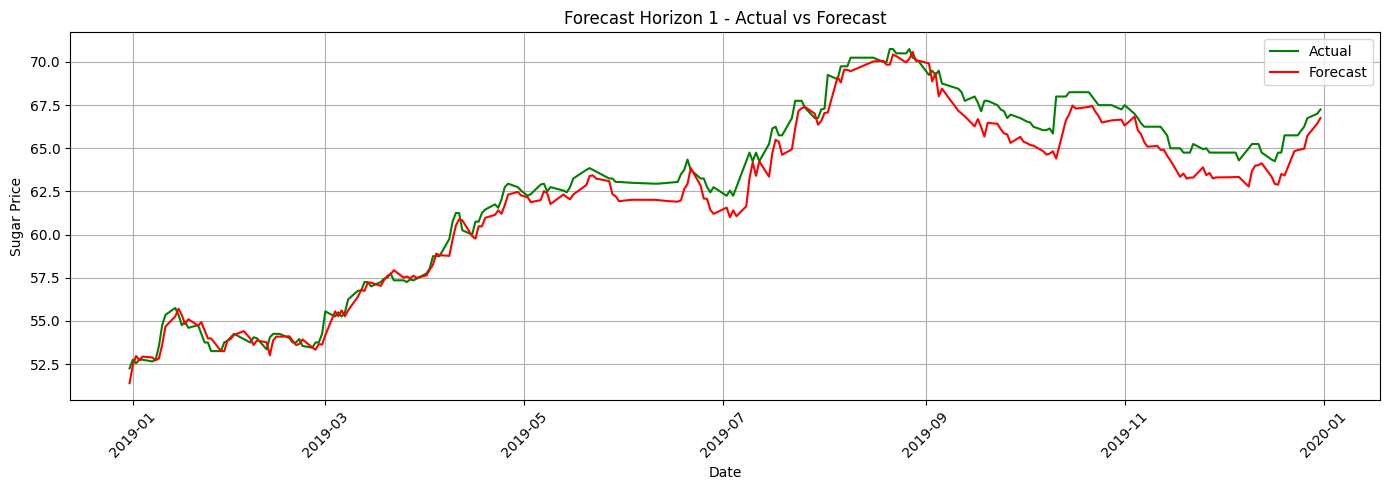

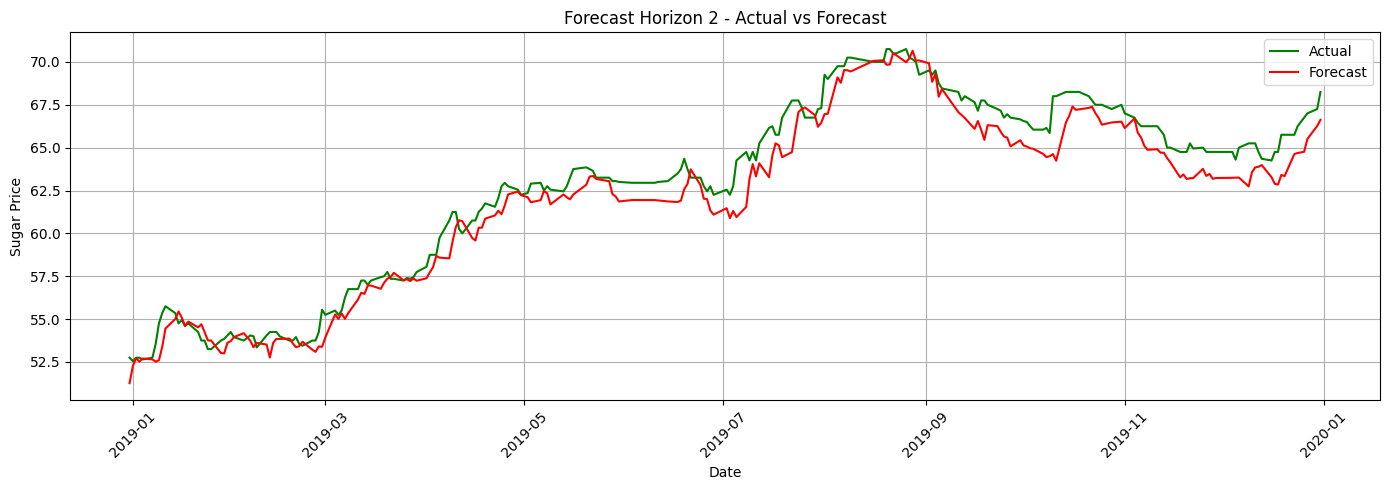

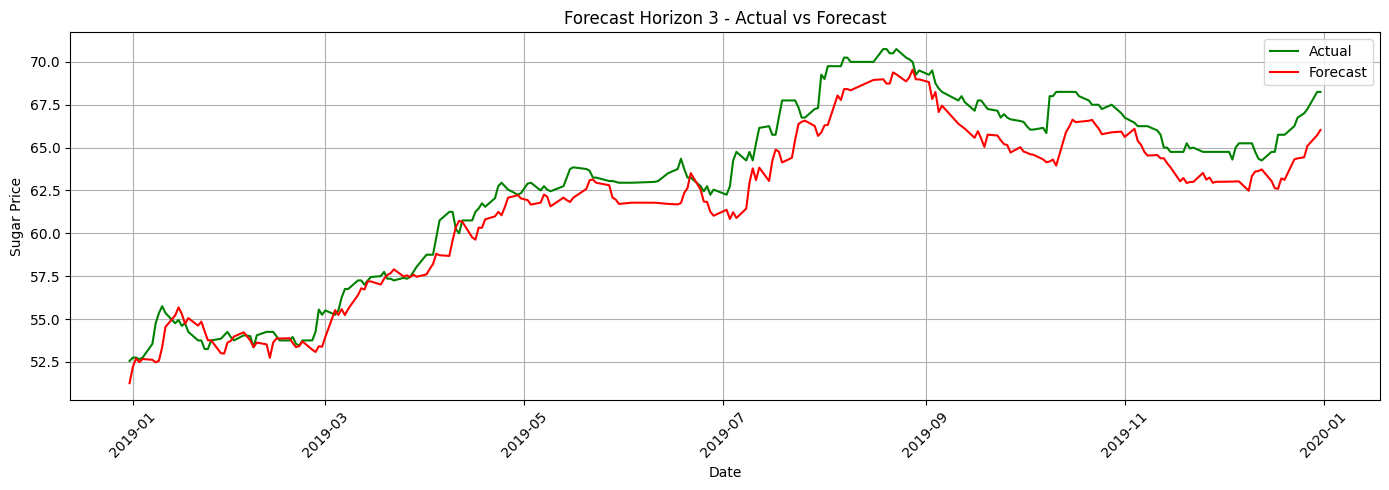

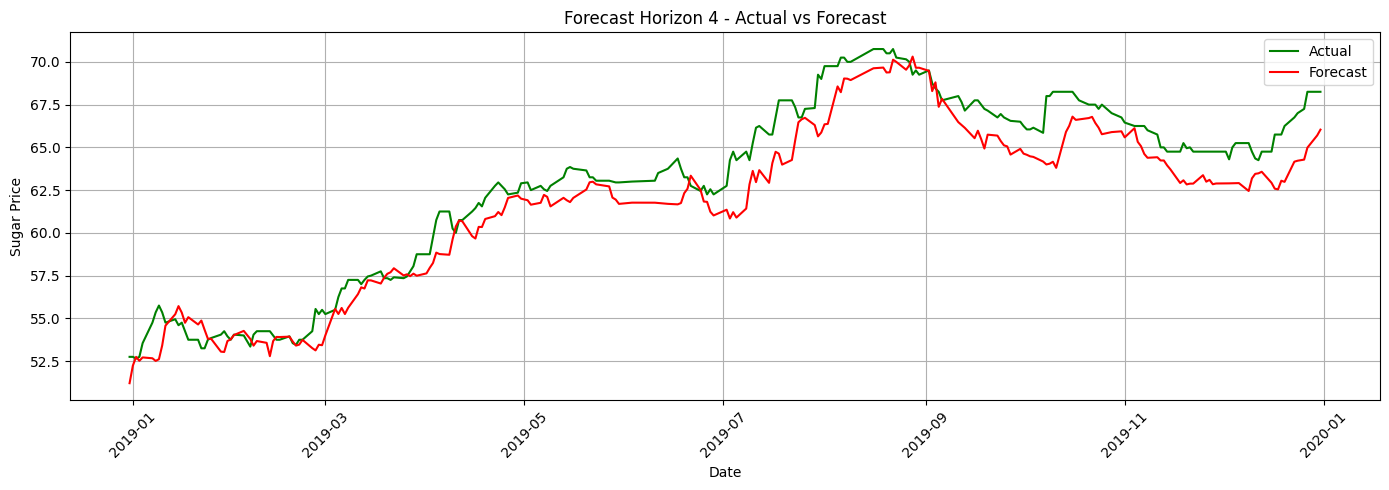

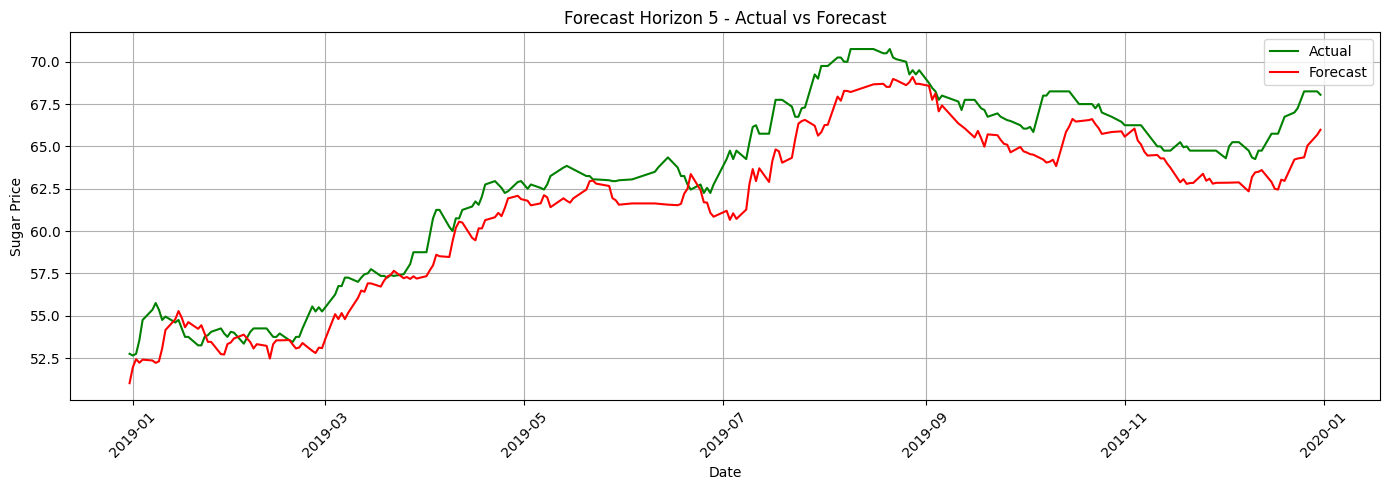

In [34]:
# Assuming your DataFrame has a DateTime index
test_dates = karachi_df.index[-n:]

# Plot for each forecast horizon
for i in range(FORECAST_HORIZON):
    plt.figure(figsize=(14, 5))
    plt.plot(test_dates, y_test_actual[:, i], label='Actual', color='green')
    plt.plot(test_dates, forecast[:, i], label='Forecast', color='red')
    plt.title(f'Forecast Horizon {i+1} - Actual vs Forecast')
    plt.xlabel('Date')
    plt.ylabel('Sugar Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

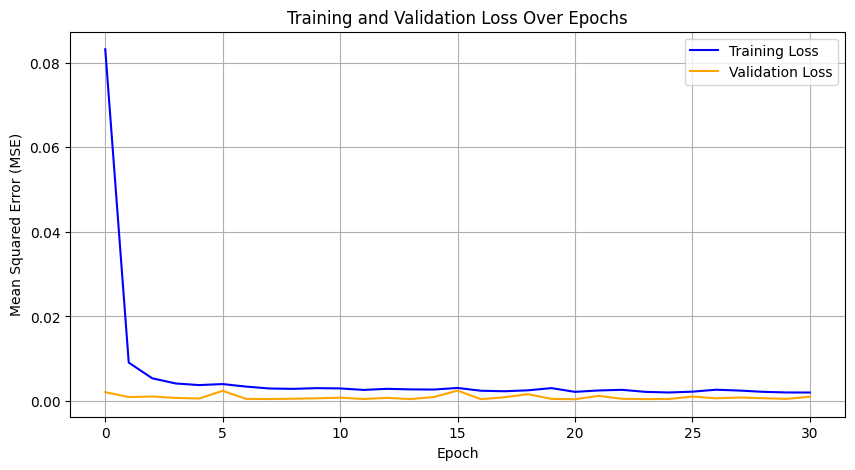

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

#XGBoost on Provincial DF:

In [ ]:
punjab_df = punjab_df.reset_index()

In [ ]:
punjab_df['date'] = pd.to_datetime(punjab_df['date'])
# Set 'date' as the index
punjab_df.set_index('date', inplace=True)

[0]	validation_0-rmse:527.50763	validation_1-rmse:1296.98826
[100]	validation_0-rmse:213.12910	validation_1-rmse:593.16966
[200]	validation_0-rmse:93.76198	validation_1-rmse:320.37213
[300]	validation_0-rmse:49.61113	validation_1-rmse:198.89543
[400]	validation_0-rmse:33.14816	validation_1-rmse:150.00531
[500]	validation_0-rmse:26.33834	validation_1-rmse:130.13551
[600]	validation_0-rmse:22.92787	validation_1-rmse:121.57775
[700]	validation_0-rmse:20.71583	validation_1-rmse:116.92440
[800]	validation_0-rmse:18.92315	validation_1-rmse:115.27623
[900]	validation_0-rmse:17.49257	validation_1-rmse:113.85904
[999]	validation_0-rmse:16.08228	validation_1-rmse:113.38789


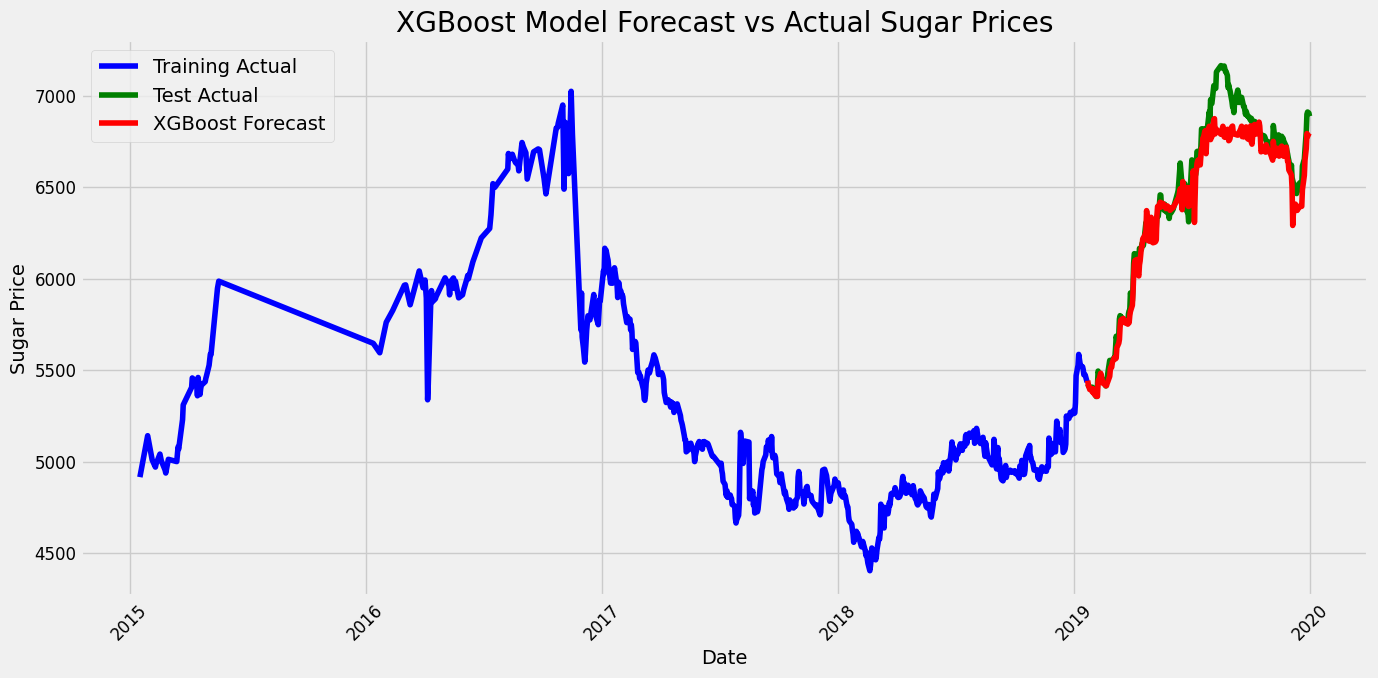

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Feature Engineering
def create_features(df, lags=5, rolling_window=3):
    df_feat = df.copy()
    for lag in range(1, lags + 1):
      df_feat[f'lag_{lag}'] = df_feat['price'].shift(lag)
      df_feat['rolling_mean'] = df_feat['price'].rolling(window=rolling_window).mean()
      df_feat['rolling_std'] = df_feat['price'].rolling(window=rolling_window).std()
      df_feat['month'] = df_feat.index.month
      df_feat['day'] = df_feat.index.day
      df_feat['dayofweek'] = df_feat.index.dayofweek
      return df_feat.dropna()

df_features = create_features(punjab_df, lags=5, rolling_window=3)

# Train-Test Split
n = 240  # Number of test samples
train_features, test_features = df_features[:-n], df_features[-n:]

X_train = train_features.drop('price', axis=1)
y_train = train_features['price']
X_test = test_features.drop('price', axis=1)
y_test = test_features['price']

# Model Training
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Early Stopping
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100
)

# Prediction
forecast = xgb_model.predict(X_test)

# Preparing Dates for Plotting
test_dates = test_features.index

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(train_features.index, y_train, label='Training Actual', color='blue')
plt.plot(test_dates, y_test, label='Test Actual', color='green')
plt.plot(test_dates, forecast, label='XGBoost Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Sugar Price')
plt.title('XGBoost Model Forecast vs Actual Sugar Prices')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Evaluation Metrics
mse = mean_squared_error(y_test, forecast)
mae = mean_absolute_error(y_test, forecast)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, forecast)
r2 = r2_score(y_test, forecast)

print(f'XGBoost Evaluation Metrics:')
print(f'---------------------------')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'R-squared (R²) Score: {r2:.4f}')

XGBoost Evaluation Metrics:
---------------------------
Mean Squared Error (MSE): 12856.8142
Mean Absolute Error (MAE): 79.1281
Root Mean Squared Error (RMSE): 113.3879
Mean Absolute Percentage Error (MAPE): 0.01%
R-squared (R²) Score: 0.9500


# LSTM on Punjab DF:

Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.1042 - val_loss: 0.0020
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0042 - val_loss: 3.8920e-04
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019 - val_loss: 4.0594e-04
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - val_loss: 4.1868e-04
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - val_loss: 3.9409e-04
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - val_loss: 3.3968e-04
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016 - val_loss: 3.2934e-04
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013 - val_loss: 2.8015e-04
Epoch 9/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - val_loss: 3.2257e-04
Epoch 10/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - val_loss: 2.8708e-04
Epoch 11/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - val_loss: 2.4538e-04
Epoch 12/20
47/47 ━━━━━━━━━━━━━━━

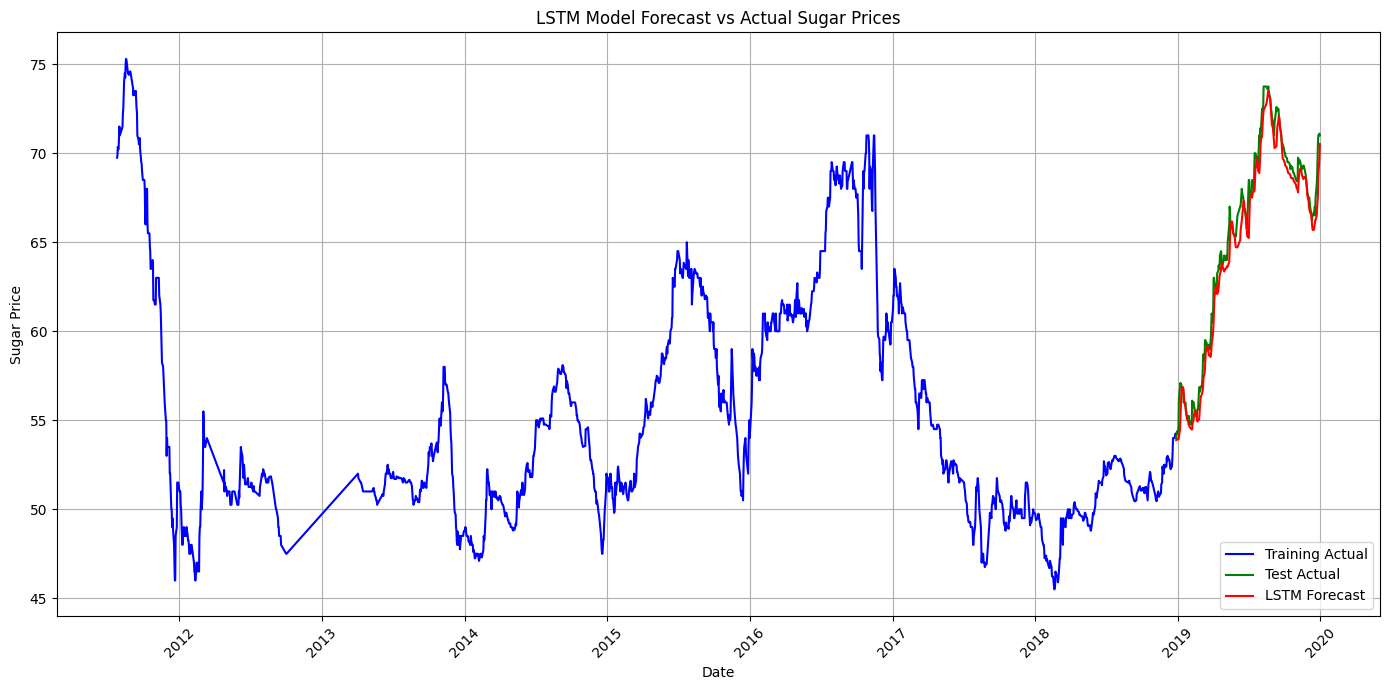

In [31]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

punjab_df = punjab_df.sort_index()

# Data Preparation
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(punjab_df.values.reshape(-1, 1))

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

SEQ_LENGTH = 10
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Train-Test Split
n = 240  # Number of test samples
X_train, X_test = X[:-n], X[-n:]
y_train, y_test = y[:-n], y[-n:]

# Reshape for LSTM [samples, time_steps, features]
X_train = X_train.reshape((X_train.shape[0], SEQ_LENGTH, 1))
X_test = X_test.reshape((X_test.shape[0], SEQ_LENGTH, 1))

# Model Building
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(SEQ_LENGTH, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Training
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# Prediction
forecast_scaled = model.predict(X_test)
forecast = scaler.inverse_transform(forecast_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluation
mse = mean_squared_error(y_test_actual, forecast)
print(f'LSTM MSE: {mse}')

# Preparing Dates for Plotting
# All dates corresponding to the sequences (excluding the first SEQ_LENGTH dates)
all_dates = punjab_df.index[SEQ_LENGTH:]

# Split dates into training and testing
train_dates = all_dates[:-n]
test_dates = all_dates[-n:]

# Inverse transform y_train for plotting
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

# Plotting
plt.figure(figsize=(14, 7))

# Plot Training Data
plt.plot(
    train_dates,
    y_train_actual,
    label='Training Actual',
    color='blue'
)

# Plot Actual Test Data
plt.plot(
    test_dates,
    y_test_actual,
    label='Test Actual',
    color='green'
)

# Plot Forecasted Data
plt.plot(
    test_dates,
    forecast,
    label='LSTM Forecast',
    color='red'
)

# Enhancements for Clarity
plt.xlabel('Date')
plt.ylabel('Sugar Price')
plt.title('LSTM Model Forecast vs Actual Sugar Prices')
plt.legend()
plt.grid(True)

# Improve Date Formatting on X-axis
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, accuracy_score

mse = mean_squared_error(y_test_actual, forecast)
mae = mean_absolute_error(y_test_actual, forecast)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test_actual, forecast)
r2 = r2_score(y_test_actual, forecast)

print(f'LSTM Evaluation Metrics:')
print(f'------------------------')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'R-squared (R²) Score: {r2:.4f}')

LSTM Evaluation Metrics:
------------------------
Mean Squared Error (MSE): 0.8401
Mean Absolute Error (MAE): 0.6746
Root Mean Squared Error (RMSE): 0.9166
Mean Absolute Percentage Error (MAPE): 0.01%
R-squared (R²) Score: 0.9750


In [42]:
punjab_act = pd.DataFrame({
    'date': train_dates,
    'province': "Punjab",
    'price': y_train_actual.flatten()
})

punjab_pred = pd.DataFrame({
    'date': test_dates,
    'province': "Punjab",
    'actual_price': y_test_actual.flatten(),
    'predicted_price': forecast.flatten()
})

In [41]:
punjab_pred

,date,province,actual_price,predicted_price
0,2018-12-28,Punjab,54.00,53.883724
1,2018-12-31,Punjab,54.40,53.913128
2,2019-01-01,Punjab,54.30,53.971172
3,2019-01-02,Punjab,54.25,53.964470
4,2019-01-03,Punjab,54.75,53.936432
...,...,...,...,...
235,2019-12-24,Punjab,68.75,66.968773
236,2019-12-26,Punjab,70.50,67.590958
237,2019-12-27,Punjab,71.00,68.687477
238,2019-12-30,Punjab,71.10,69.751709


# LSTM on Sindh DF:

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.0758 - val_loss: 0.0012
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0022 - val_loss: 5.2168e-04
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - val_loss: 4.2297e-04
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014 - val_loss: 4.1714e-04
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012 - val_loss: 4.0777e-04
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0010 - val_loss: 4.0400e-04
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.6387e-04 - val_loss: 3.8740e-04
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.8485e-04 - val_loss: 3.6196e-04
Epoch 9/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.4133e-04 - val_loss: 3.4011e-04
Epoch 10/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.1650e-04 - val_loss: 3.4870e-04
Epoch 11/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.7086e-04 - val_loss: 3.3133e-04
Epoch 12/20
5

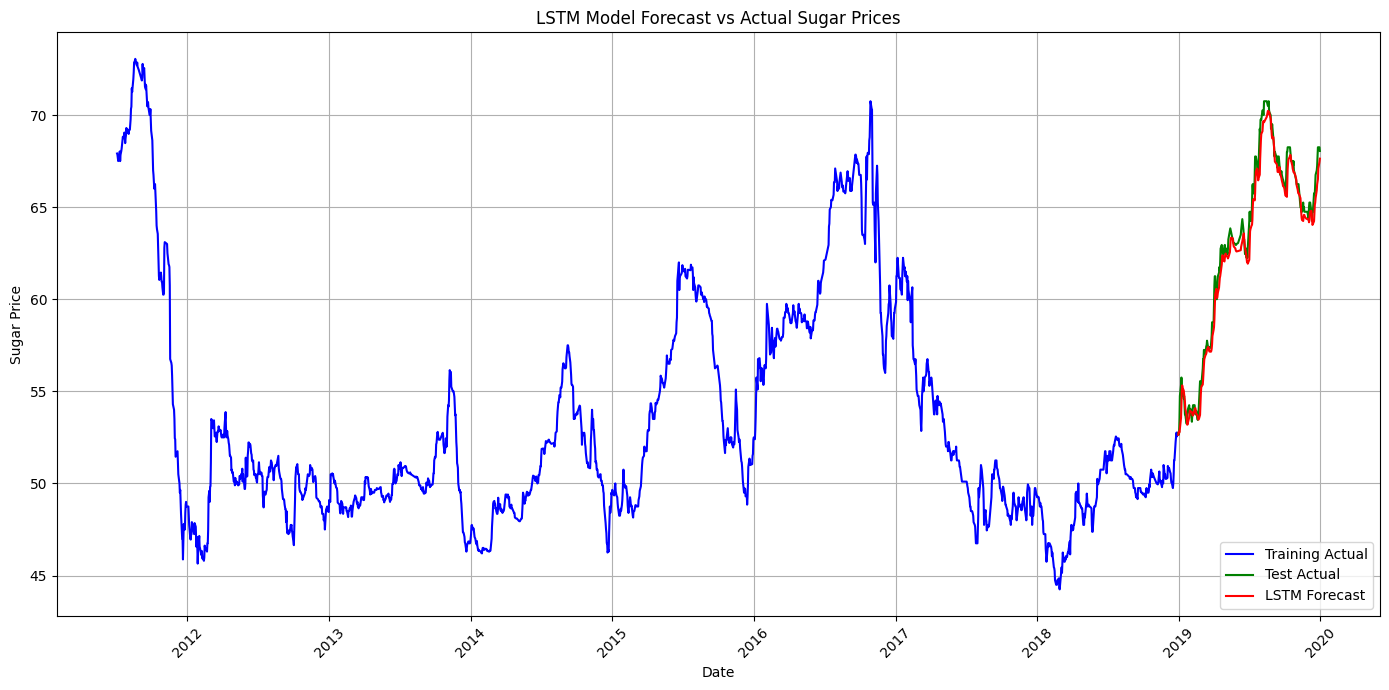

In [43]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

sindh_df = sindh_df.sort_index()

# Data Preparation
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(sindh_df.values.reshape(-1, 1))

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

SEQ_LENGTH = 10
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Train-Test Split
n = 240  # Number of test samples
X_train, X_test = X[:-n], X[-n:]
y_train, y_test = y[:-n], y[-n:]

# Reshape for LSTM [samples, time_steps, features]
X_train = X_train.reshape((X_train.shape[0], SEQ_LENGTH, 1))
X_test = X_test.reshape((X_test.shape[0], SEQ_LENGTH, 1))

# Model Building
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(SEQ_LENGTH, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Training
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# Prediction
forecast_scaled = model.predict(X_test)
forecast = scaler.inverse_transform(forecast_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluation
mse = mean_squared_error(y_test_actual, forecast)
print(f'LSTM MSE: {mse}')

# Preparing Dates for Plotting
# All dates corresponding to the sequences (excluding the first SEQ_LENGTH dates)
all_dates = sindh_df.index[SEQ_LENGTH:]

# Split dates into training and testing
train_dates = all_dates[:-n]
test_dates = all_dates[-n:]

# Inverse transform y_train for plotting
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

# Plotting
plt.figure(figsize=(14, 7))

# Plot Training Data
plt.plot(
    train_dates,
    y_train_actual,
    label='Training Actual',
    color='blue'
)

# Plot Actual Test Data
plt.plot(
    test_dates,
    y_test_actual,
    label='Test Actual',
    color='green'
)

# Plot Forecasted Data
plt.plot(
    test_dates,
    forecast,
    label='LSTM Forecast',
    color='red'
)

# Enhancements for Clarity
plt.xlabel('Date')
plt.ylabel('Sugar Price')
plt.title('LSTM Model Forecast vs Actual Sugar Prices')
plt.legend()
plt.grid(True)

# Improve Date Formatting on X-axis
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, accuracy_score

mse = mean_squared_error(y_test_actual, forecast)
mae = mean_absolute_error(y_test_actual, forecast)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test_actual, forecast)
r2 = r2_score(y_test_actual, forecast)

print(f'LSTM Evaluation Metrics:')
print(f'------------------------')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'R-squared (R²) Score: {r2:.4f}')

LSTM Evaluation Metrics:
------------------------
Mean Squared Error (MSE): 0.5503
Mean Absolute Error (MAE): 0.5597
Root Mean Squared Error (RMSE): 0.7418
Mean Absolute Percentage Error (MAPE): 0.01%
R-squared (R²) Score: 0.9798


In [45]:
sindh_act = pd.DataFrame({
    'date': train_dates,
    'province': "Sindh",
    'price': y_train_actual.flatten()
})

sindh_pred = pd.DataFrame({
    'date': test_dates,
    'province': "Sindh",
    'actual_price': y_test_actual.flatten(),
    'predicted_price': forecast.flatten()
})

# LSTM on KPK DF:

In [70]:
train = kpk_df[kpk_df.index <= pd.to_datetime("2019-01-01", format='%Y-%m-%d')]
test = kpk_df[kpk_df.index >= pd.to_datetime("2019-01-01", format='%Y-%m-%d')]

In [71]:
test

,price
date,
2019-01-01,5320.0
2019-01-02,5220.0
2019-01-04,5470.0
2019-01-07,5512.5
2019-01-08,5597.5
...,...
2019-12-24,6687.5
2019-12-26,6750.0
2019-12-27,6805.0


Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 498ms/step - loss: 0.0735 - val_loss: 0.0839
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0704 - val_loss: 0.0652
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0454 - val_loss: 0.0479
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0363 - val_loss: 0.0320
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0230 - val_loss: 0.0185
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0152 - val_loss: 0.0088
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0091 - val_loss: 0.0046
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0078 - val_loss: 0.0039
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0088 - val_loss: 0.0039
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0060 - val_loss: 0.0052
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0048 - val_loss: 0.0075
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0043 - val_loss: 0.0084


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step
LSTM MSE: 32613.606407978798


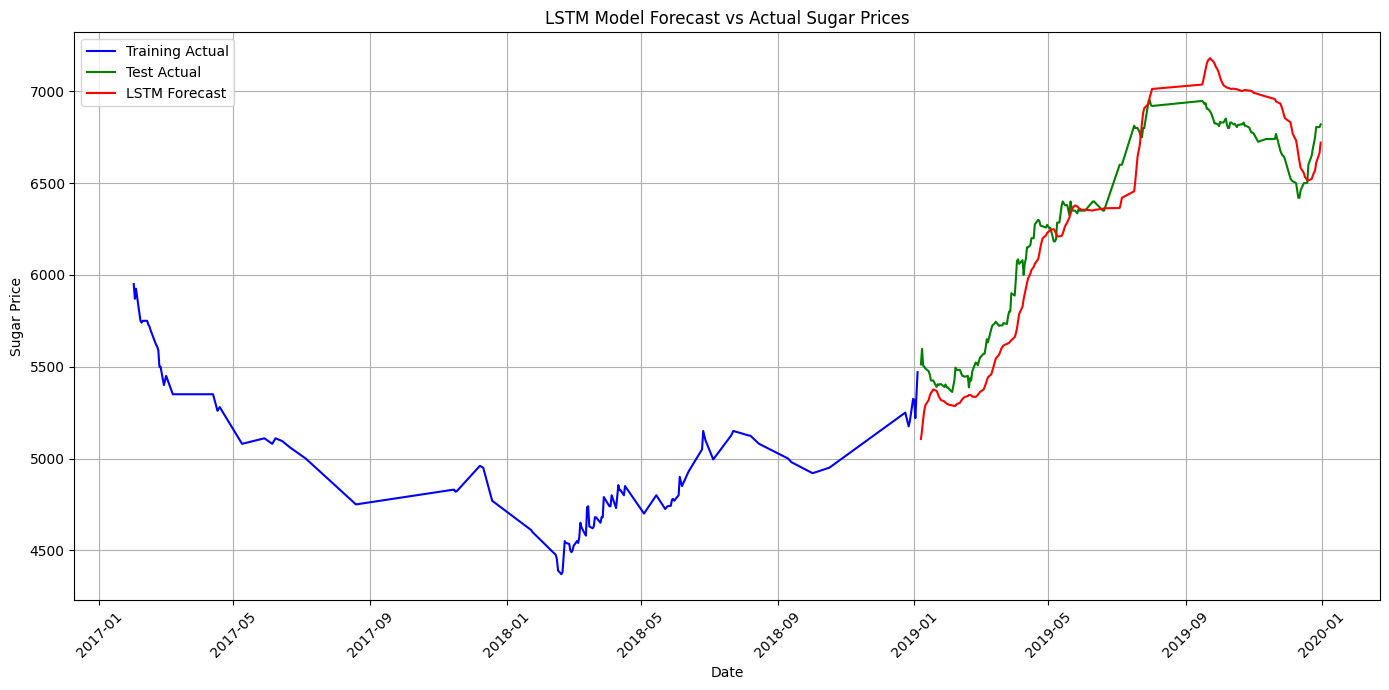

In [46]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

kpk_df = kpk_df.sort_index()

# Data Preparation
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(kpk_df.values.reshape(-1, 1))

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

SEQ_LENGTH = 10
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Train-Test Split
n = 190  # Number of test samples
X_train, X_test = X[:-n], X[-n:]
y_train, y_test = y[:-n], y[-n:]

# Reshape for LSTM [samples, time_steps, features]
X_train = X_train.reshape((X_train.shape[0], SEQ_LENGTH, 1))
X_test = X_test.reshape((X_test.shape[0], SEQ_LENGTH, 1))

# Model Building
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(SEQ_LENGTH, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Training
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# Prediction
forecast_scaled = model.predict(X_test)
forecast = scaler.inverse_transform(forecast_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluation
mse = mean_squared_error(y_test_actual, forecast)
print(f'LSTM MSE: {mse}')

# Preparing Dates for Plotting
# All dates corresponding to the sequences (excluding the first SEQ_LENGTH dates)
all_dates = kpk_df.index[SEQ_LENGTH:]

# Split dates into training and testing
train_dates = all_dates[:-n]
test_dates = all_dates[-n:]

# Inverse transform y_train for plotting
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

# Plotting
plt.figure(figsize=(14, 7))

# Plot Training Data
plt.plot(
    train_dates,
    y_train_actual,
    label='Training Actual',
    color='blue'
)

# Plot Actual Test Data
plt.plot(
    test_dates,
    y_test_actual,
    label='Test Actual',
    color='green'
)

# Plot Forecasted Data
plt.plot(
    test_dates,
    forecast,
    label='LSTM Forecast',
    color='red'
)

# Enhancements for Clarity
plt.xlabel('Date')
plt.ylabel('Sugar Price')
plt.title('LSTM Model Forecast vs Actual Sugar Prices')
plt.legend()
plt.grid(True)

# Improve Date Formatting on X-axis
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, accuracy_score

mse = mean_squared_error(y_test_actual, forecast)
mae = mean_absolute_error(y_test_actual, forecast)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test_actual, forecast)
r2 = r2_score(y_test_actual, forecast)

print(f'LSTM Evaluation Metrics:')
print(f'------------------------')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'R-squared (R²) Score: {r2:.4f}')

LSTM Evaluation Metrics:
------------------------
Mean Squared Error (MSE): 32613.6064
Mean Absolute Error (MAE): 156.8436
Root Mean Squared Error (RMSE): 180.5924
Mean Absolute Percentage Error (MAPE): 0.03%
R-squared (R²) Score: 0.8839


In [48]:
kpk_act = pd.DataFrame({
    'date': train_dates,
    'province': "KPK",
    'price': y_train_actual.flatten()
})

kpk_pred = pd.DataFrame({
    'date': test_dates,
    'province': "KPK",
    'actual_price': y_test_actual.flatten(),
    'predicted_price': forecast.flatten()
})

In [51]:
#CSV FOR ALL THE PROVINCES:

actual = pd.concat([punjab_act, sindh_act, kpk_act])
pred = pd.concat([punjab_pred, sindh_pred, kpk_pred])

In [52]:
actual.to_csv('sugar_province_actual.csv')
pred.to_csv('sugar_province_pred.csv')

# SARIMA:

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}52 - AIC:{}'.format(param, param_seasonal, results.aic))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 0, 0)x(0, 0, 0, 12)52 - AIC:20561.1948350797
ARIMA(0, 0, 0)x(0, 0, 1, 12)52 - AIC:17915.459904863783
ARIMA(0, 0, 0)x(0, 1, 0, 12)52 - AIC:8127.042938205173


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 0, 0)x(0, 1, 1, 12)52 - AIC:8047.826511704567


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 0, 0)x(1, 0, 0, 12)52 - AIC:8122.603235137636


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 0, 0)x(1, 0, 1, 12)52 - AIC:8082.268750540744
ARIMA(0, 0, 0)x(1, 1, 0, 12)52 - AIC:8052.117525498088


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 0, 0)x(1, 1, 1, 12)52 - AIC:8049.825544198929


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 0, 1)x(0, 0, 0, 12)52 - AIC:17941.5416109648


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 0, 1)x(0, 0, 1, 12)52 - AIC:15335.512148862383


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 0, 1)x(0, 1, 0, 12)52 - AIC:6154.336081560914


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 0, 1)x(0, 1, 1, 12)52 - AIC:6125.822946548535


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 0, 1)x(1, 0, 0, 12)52 - AIC:6153.573594922585


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/di

ARIMA(0, 0, 1)x(1, 0, 1, 12)52 - AIC:6157.7715006689705
ARIMA(0, 0, 1)x(1, 1, 0, 12)52 - AIC:6131.482613708641


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 0, 1)x(1, 1, 1, 12)52 - AIC:6124.03521124126
ARIMA(0, 1, 0)x(0, 0, 0, 12)52 - AIC:2435.404951763958


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 1, 0)x(0, 0, 1, 12)52 - AIC:2424.0733197092413
ARIMA(0, 1, 0)x(0, 1, 0, 12)52 - AIC:3786.7455980327286


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 1, 0)x(0, 1, 1, 12)52 - AIC:2464.8122021782474


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/di

ARIMA(0, 1, 0)x(1, 0, 0, 12)52 - AIC:2424.684928316648
ARIMA(0, 1, 0)x(1, 0, 1, 12)52 - AIC:2425.7098119161583


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 1, 0)x(1, 1, 0, 12)52 - AIC:3208.201579769462


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 1, 0)x(1, 1, 1, 12)52 - AIC:2468.938522374237
ARIMA(0, 1, 1)x(0, 0, 0, 12)52 - AIC:2385.720286751277


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 1, 1)x(0, 0, 1, 12)52 - AIC:2374.0650238548615
ARIMA(0, 1, 1)x(0, 1, 0, 12)52 - AIC:3746.97691547101


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 1, 1)x(0, 1, 1, 12)52 - AIC:2414.6348969096057


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 1, 1)x(1, 0, 0, 12)52 - AIC:2375.1274280170164


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 1, 1)x(1, 0, 1, 12)52 - AIC:2375.6657609436725


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 1, 1)x(1, 1, 0, 12)52 - AIC:3150.9014619943623


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 1, 1)x(1, 1, 1, 12)52 - AIC:2416.15864578402
ARIMA(1, 0, 0)x(0, 0, 0, 12)52 - AIC:2436.8435516665127


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 0, 0)x(0, 0, 1, 12)52 - AIC:2432.5713495783675
ARIMA(1, 0, 0)x(0, 1, 0, 12)52 - AIC:3742.1198365445525


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 0, 0)x(0, 1, 1, 12)52 - AIC:2462.8337538401056


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 0, 0)x(1, 0, 0, 12)52 - AIC:2425.57053386672


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 0, 0)x(1, 0, 1, 12)52 - AIC:2429.6733867174357


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 0, 0)x(1, 1, 0, 12)52 - AIC:3185.1200338704043


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 0, 0)x(1, 1, 1, 12)52 - AIC:2465.8268083714083
ARIMA(1, 0, 1)x(0, 0, 0, 12)52 - AIC:2387.885141736258


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/di

ARIMA(1, 0, 1)x(0, 0, 1, 12)52 - AIC:2386.3932463422825


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 0, 1)x(0, 1, 0, 12)52 - AIC:3688.6270311156036


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 0, 1)x(0, 1, 1, 12)52 - AIC:2411.0147607094345


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 0, 1)x(1, 0, 0, 12)52 - AIC:2376.1680806503346


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/di

ARIMA(1, 0, 1)x(1, 0, 1, 12)52 - AIC:2377.336327607484
ARIMA(1, 0, 1)x(1, 1, 0, 12)52 - AIC:3119.863790520164


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 0, 1)x(1, 1, 1, 12)52 - AIC:2412.1111996685613
ARIMA(1, 1, 0)x(0, 0, 0, 12)52 - AIC:2379.747603619273


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 1, 0)x(0, 0, 1, 12)52 - AIC:2367.614816623327
ARIMA(1, 1, 0)x(0, 1, 0, 12)52 - AIC:3743.6534770320404


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 1, 0)x(0, 1, 1, 12)52 - AIC:2408.626094368629
ARIMA(1, 1, 0)x(1, 0, 0, 12)52 - AIC:2367.8103723244826


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 1, 0)x(1, 0, 1, 12)52 - AIC:2369.6176952235364


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 1, 0)x(1, 1, 0, 12)52 - AIC:3140.784275977019


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 1, 0)x(1, 1, 1, 12)52 - AIC:2410.173725194171
ARIMA(1, 1, 1)x(0, 0, 0, 12)52 - AIC:2368.813996114685


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 1, 1)x(0, 0, 1, 12)52 - AIC:2356.7000162721097


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 1, 1)x(0, 1, 0, 12)52 - AIC:3739.992891783617


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 1, 1)x(0, 1, 1, 12)52 - AIC:2398.1117927746163


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 1, 1)x(1, 0, 0, 12)52 - AIC:2357.6437341537066


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 1, 1)x(1, 0, 1, 12)52 - AIC:2358.532682178311


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 1, 1)x(1, 1, 0, 12)52 - AIC:3133.8210164939833


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 1, 1)x(1, 1, 1, 12)52 - AIC:2399.2218172223756


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

SARIMAXmodel = SARIMAX(train, order=(1,1,1),seasonal_order=(1, 1, 1, 364))
SARIMAXmodel = SARIMAXmodel.fit()

#Train set prediction
y_pred_train = SARIMAXmodel.get_forecast(len(train.index)) #only providing dates (train.index) from train as input for forecasting
y_pred_df_train = y_pred_train.conf_int(alpha = 0.05)
y_pred_df_train["Predictions"] = SARIMAXmodel.predict(start = y_pred_df_train.index[0], end = y_pred_df_train.index[-1])

#for training prediction plotting purposes
y_pred_df_train.index = train.index
y_pred_out_train = y_pred_df_train["Predictions"]

#Test set prediction
y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05)
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])

#for testing prediction plotting purposes
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"]

plt.plot(train, color = "black", label = 'Train')
plt.plot(test, color = "red", label = 'Test')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Temperature Data")

plt.plot(y_pred_out_train, color='blue', label = 'Train Predictions')

plt.plot(y_pred_out, color='green', label = 'Test Predictions')
plt.legend()
plt.show()

import numpy as np
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(test.values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

C:\Users\ryash\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ryash\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ryash\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ryash\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


MemoryError: Unable to allocate 648. MiB for an array with shape (731, 731, 159) and data type float64

In [ ]:
dataset = dfs.get(('Karachi', 'sugar_mills'))
if datasets:
    train_df = datasets['train']
    test_df = datasets['test']
else:
    print(f"No data found for Station: {station}, By-Product: {by_product}")

In [ ]:
train_df

,date,price
0,2017-12-24 00:00:00,130.0
1,2017-12-31 00:00:00,130.0
2,2018-01-07 00:00:00,NaN
3,2018-01-14 00:00:00,130.0
4,2018-01-21 00:00:00,130.0
...,...,...
93,2019-10-06 00:00:00,NaN
94,2019-10-13 00:00:00,NaN
95,2019-10-20 00:00:00,NaN
96,2019-10-27 00:00:00,NaN


In [ ]:
train_df = train_df.set_index('date')
train_df

,price
date,
2017-12-24,130.0
2017-12-31,130.0
2018-01-07,NaN
2018-01-14,130.0
2018-01-21,130.0
...,...
2019-10-06,NaN
2019-10-13,NaN
2019-10-20,NaN


In [ ]:
#RF REGRESSOR
for key, datasets in dfs.items():
    station, by_product = key
    train_df = datasets['train'].copy()
    test_df = datasets['test'].copy()
    train_df['date'] = pd.to_datetime(train_df['date'])
    test_df['date'] = pd.to_datetime(test_df['date'])

    # Feature Engineering on Training Data
    train_df['month'] = train_df['date'].dt.month
    train_df['year'] = train_df['date'].dt.year
    train_df['price_lag1'] = train_df['price'].shift(1)
    train_df['price_lag2'] = train_df['price'].shift(2)
    train_df.dropna(inplace=True)  # Drop rows with NaN values due to lag

    # Features and Target
    features = ['month', 'year', 'price_lag1', 'price_lag2']
    target = 'price'

    X_train = train_df[features]
    y_train = train_df[target]

    # Feature Engineering on Testing Data
    last_price_lag1 = train_df['price'].iloc[-1]
    last_price_lag2 = train_df['price'].iloc[-2]
    test_df['weekofyear'] = test_df['date'].dt.isocalendar().week.astype(int)
    test_df['month'] = test_df['date'].dt.month
    test_df['year'] = test_df['date'].dt.year
    test_df['price_lag1'] = last_price_lag1
    test_df['price_lag2'] = last_price_lag2

    X_test = test_df[features]
    y_test = test_df[target]

    # Train the model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    predictions = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, predictions)
    print(f"Station: {station}, By-Product: {by_product}, MSE: {mse}")

DateParseError: Unknown datetime string format, unable to parse: station, at position 9

In [ ]:
df.sort_values('datetime')
df.isnull().sum()

datetime    0
temp        0
dtype: int64

In [ ]:
df = df.set_index('datetime')

In [ ]:
df

,temp
datetime,
2021-01-01,15.0
2021-01-02,15.4
2021-01-03,15.6
2021-01-04,16.3
2021-01-05,17.1
...,...
2023-04-22,29.5
2023-04-23,30.0
2023-04-24,30.4


In [ ]:
weekly_df = df['temp'].resample('W').mean()

In [ ]:
weekly_df.head()

datetime
2021-01-03    15.333333
2021-01-10    16.028571
2021-01-17    17.085714
2021-01-24    19.457143
2021-01-31    17.800000
Freq: W-SUN, Name: temp, dtype: float64

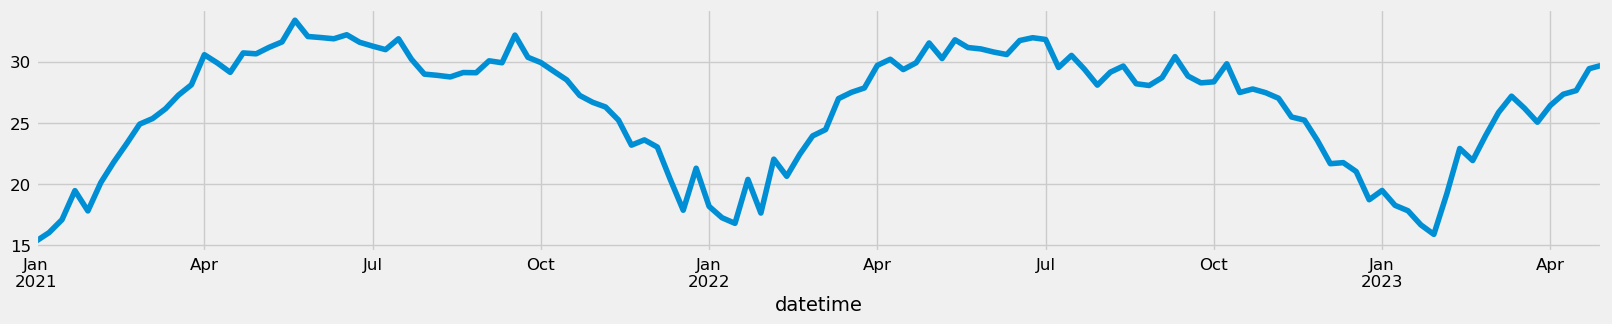

In [ ]:
weekly_df.plot(figsize=(18, 3))
plt.show()

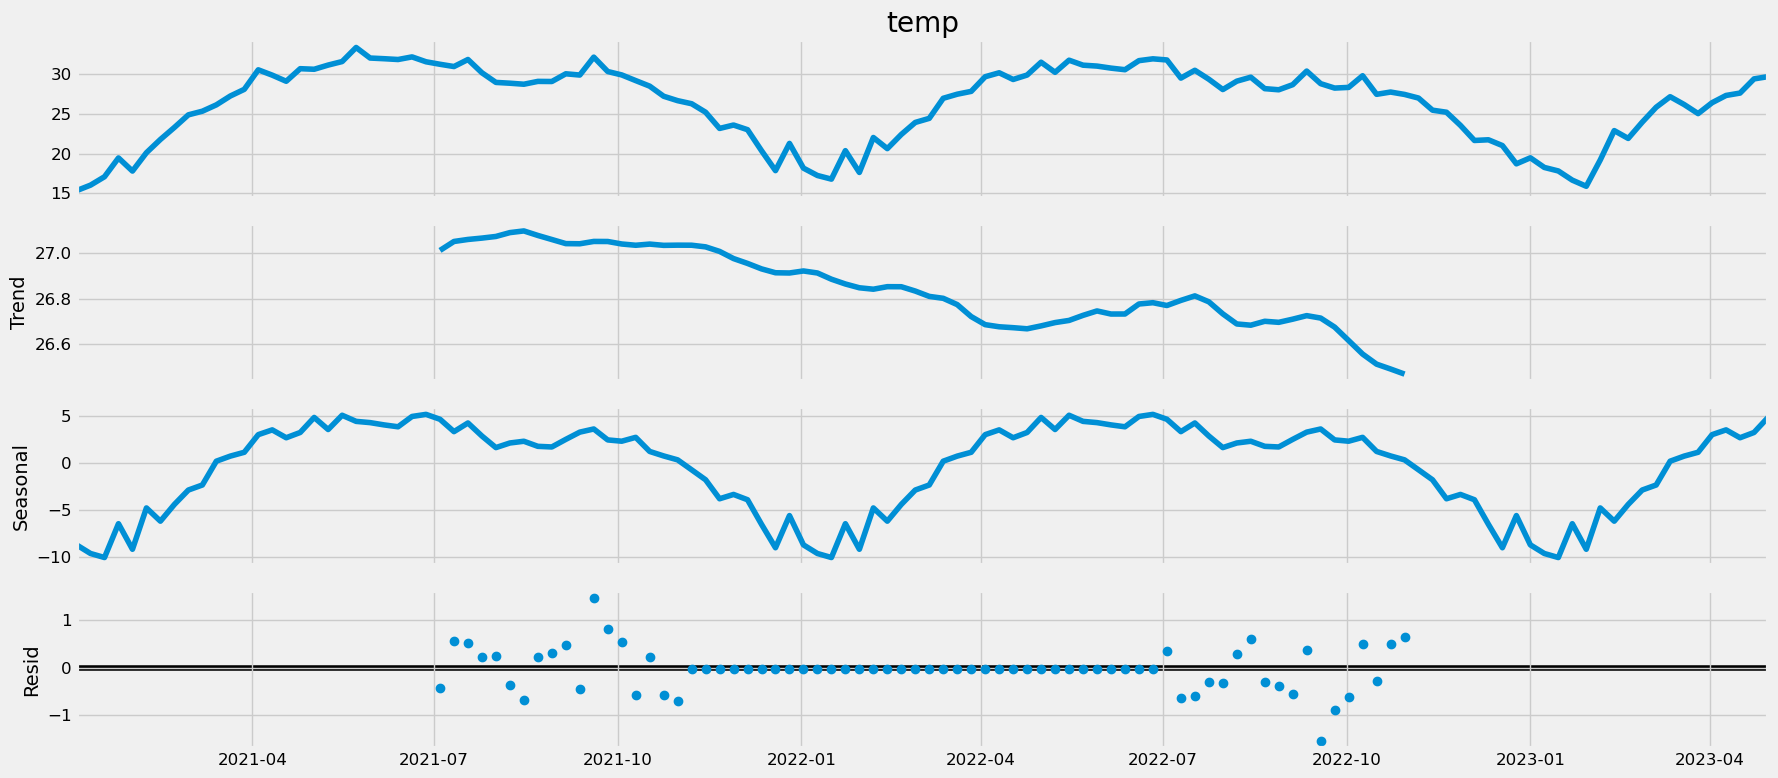

In [ ]:
decomposition = sm.tsa.seasonal_decompose(weekly_df, model='additive')
rcParams['figure.figsize'] = 18, 8
fig = decomposition.plot()
plt.show()

#### Observations:

The observed data shows the overall temperature pattern over time. There is a clear cyclical pattern, indicating seasonal temperature variations across the years. Temperatures peak around the mid-year and dip towards the end of the year, which corresponds to Karachi's hot summers and cooler winters.

The trend component highlights the underlying trend in temperature changes over time, excluding seasonal and irregular components. It appears relatively steady, though it slightly fluctuates over time. There is a gentle downward trend mid-period and a recovery towards the end, showing minor long-term changes in temperature.

The seasonal component exhibits a regular repeating pattern, signifying the cyclical temperature changes within each year. This seasonality aligns with Karachi’s typical climate, where temperatures are high in summer and lower in winter.

The residuals capture random fluctuations that are not explained by the trend or seasonality. Most residual values are close to zero, with a few scattered points that could indicate minor anomalies or irregularities.

## Modeling

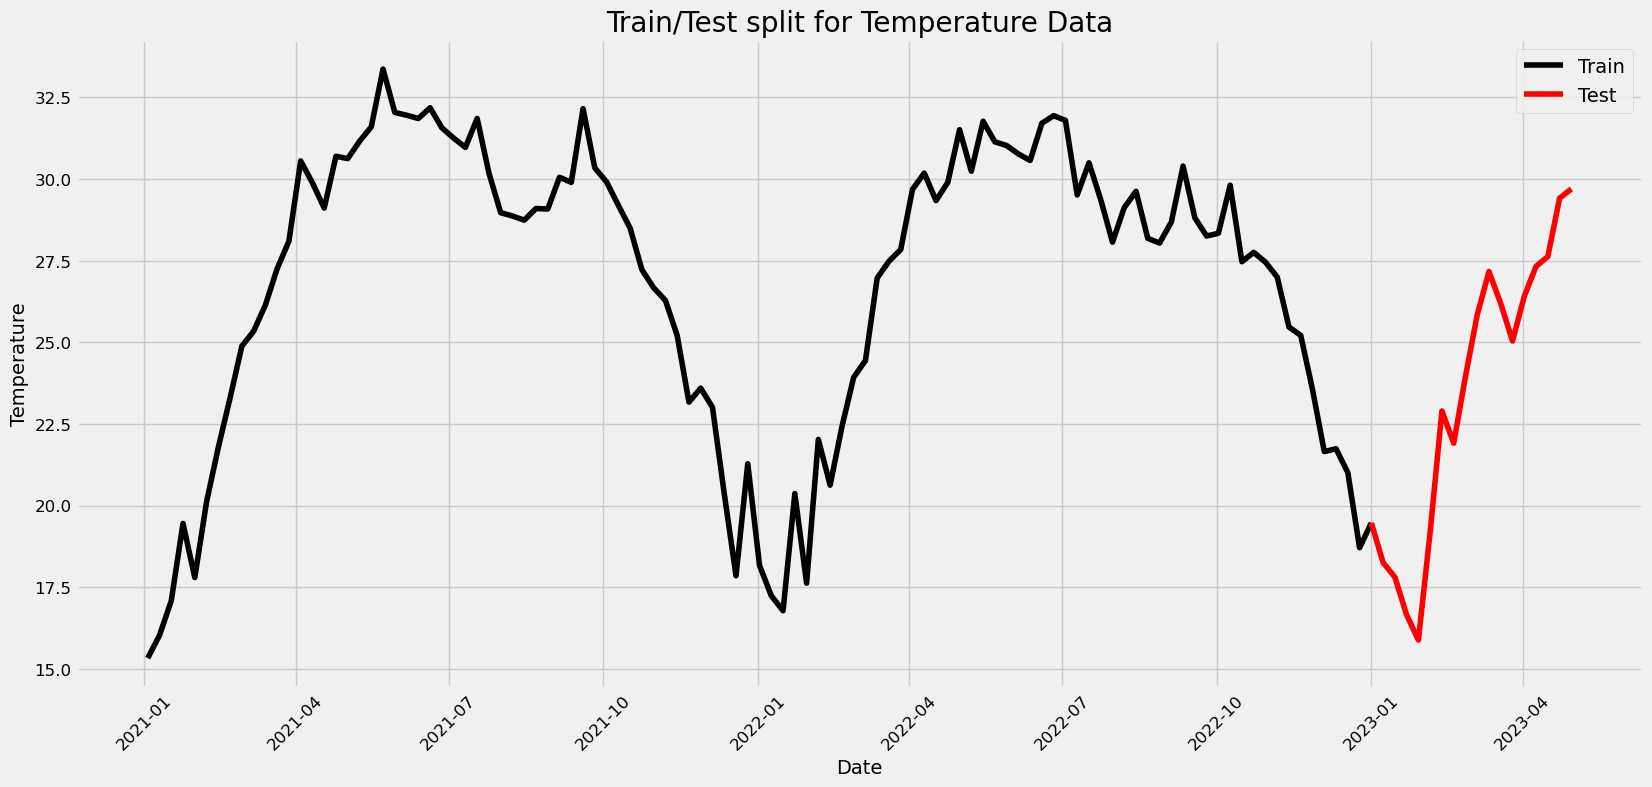

In [ ]:
train = weekly_df[weekly_df.index <= pd.to_datetime("2023-01-01", format='%Y-%m-%d')]
test = weekly_df[weekly_df.index >= pd.to_datetime("2023-01-01", format='%Y-%m-%d')]

plt.plot(train, color = "black", label = 'Train')
plt.plot(test, color = "red", label = 'Test')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Temperature Data")
plt.legend()
plt.show()

## Using Statistical Models

## ARIMA
ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It assumes that data is stationary with no seasonality

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

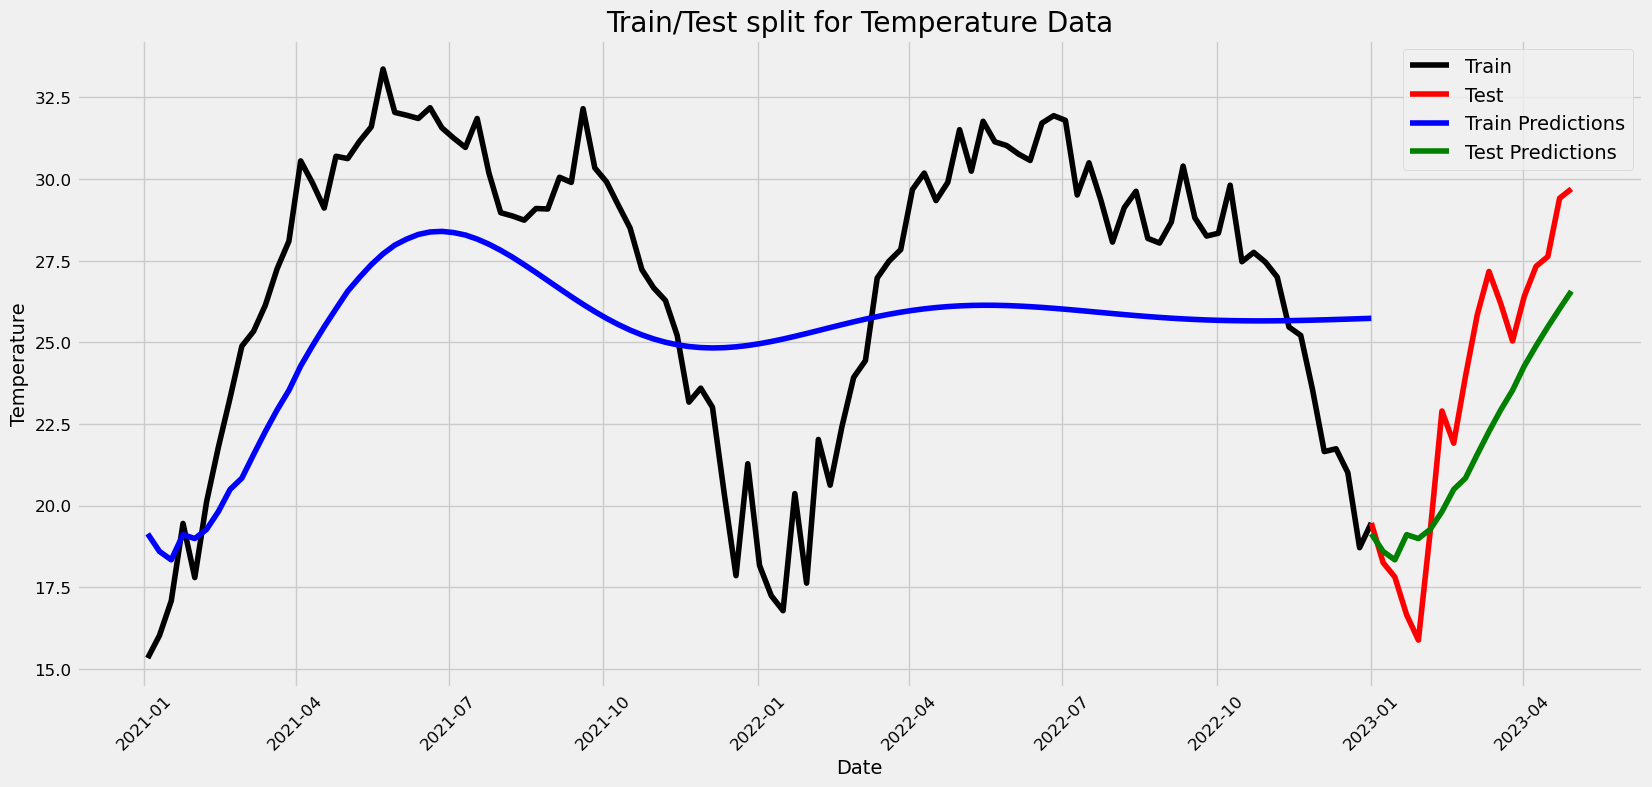

RMSE:  2.676078588164248


In [ ]:
ARIMAmodel = ARIMA(train, order = (5,0,0))
ARIMAmodel = ARIMAmodel.fit()

#Train set prediction
y_pred_train = ARIMAmodel.get_forecast(len(train.index)) #only providing dates (train.index) from train as input for forecasting
y_pred_df_train = y_pred_train.conf_int(alpha = 0.05)
y_pred_df_train["Predictions"] = ARIMAmodel.predict(start = y_pred_df_train.index[0], end = y_pred_df_train.index[-1])

#for training prediction plotting purposes
y_pred_df_train.index = train.index
y_pred_out_train = y_pred_df_train["Predictions"]

#Train set prediction
y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05)
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])

#for testing prediction plotting purposes
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"]

plt.plot(train, color = "black", label = 'Train')
plt.plot(test, color = "red", label = 'Test')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Temperature Data")

plt.plot(y_pred_out_train, color='blue', label = 'Train Predictions')

plt.plot(y_pred_out, color='green', label = 'Test Predictions')
plt.legend()
plt.show()

import numpy as np
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(test.values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

In [ ]:
print(ARIMAmodel.summary())

                               SARIMAX Results                                
Dep. Variable:                   temp   No. Observations:                  105
Model:                 ARIMA(5, 0, 0)   Log Likelihood                -166.044
Date:                Mon, 11 Nov 2024   AIC                            346.088
Time:                        19:49:59   BIC                            364.666
Sample:                    01-03-2021   HQIC                           353.616
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.7878      1.556     16.577      0.000      22.739      28.837
ar.L1          0.6755      0.087      7.779      0.000       0.505       0.846
ar.L2          0.4121      0.105      3.928      0.0

# SARIMA

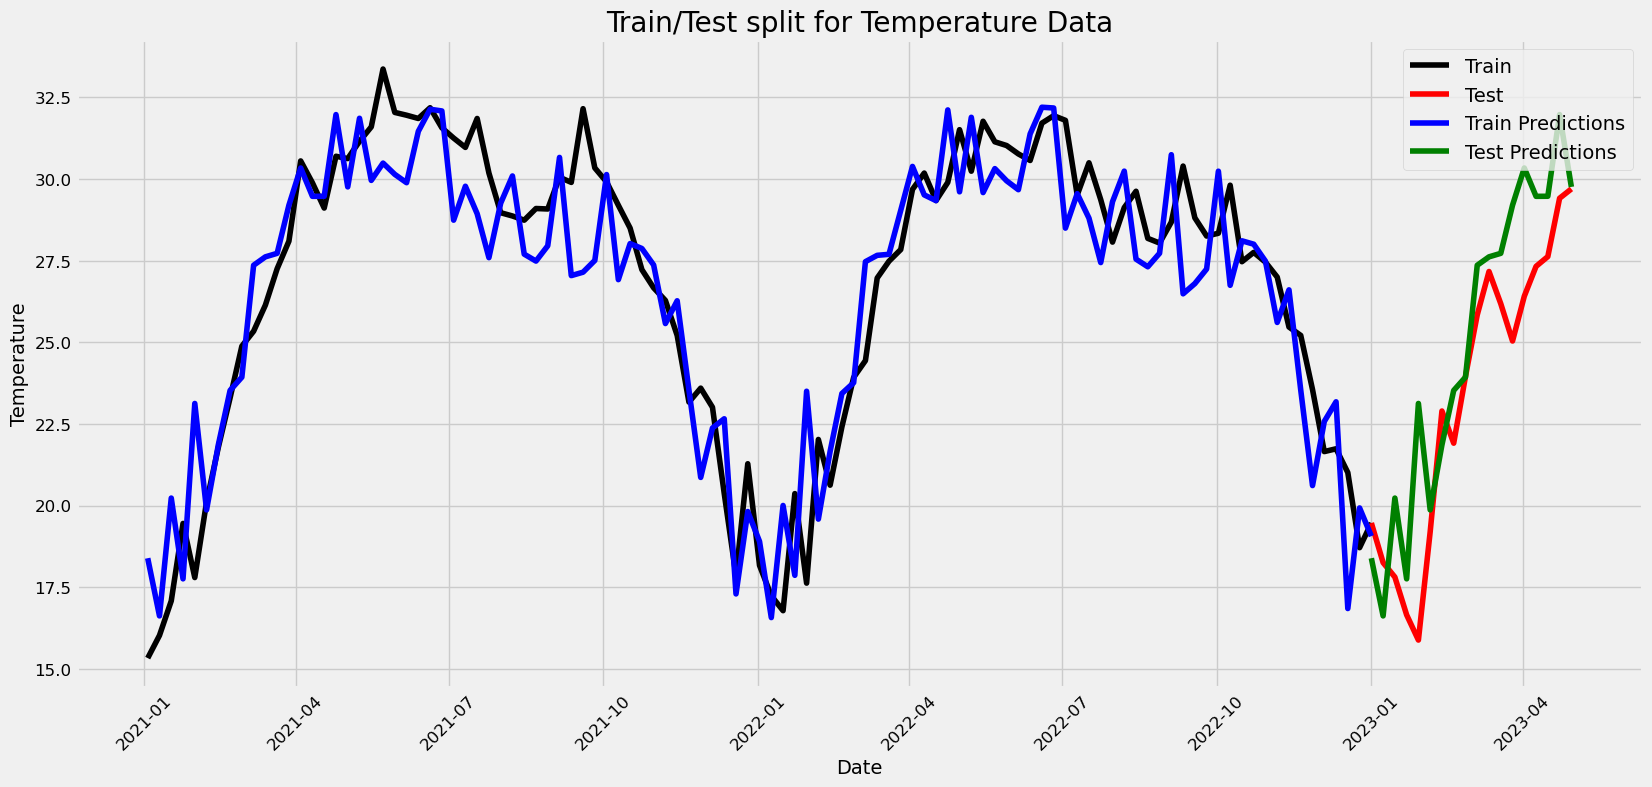

RMSE:  2.578793069736221


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

SARIMAXmodel = SARIMAX(train, order=(5,0,0),seasonal_order=(1, 1, 1, 52))
SARIMAXmodel = SARIMAXmodel.fit()

#Train set prediction
y_pred_train = SARIMAXmodel.get_forecast(len(train.index)) #only providing dates (train.index) from train as input for forecasting
y_pred_df_train = y_pred_train.conf_int(alpha = 0.05)
y_pred_df_train["Predictions"] = SARIMAXmodel.predict(start = y_pred_df_train.index[0], end = y_pred_df_train.index[-1])

#for training prediction plotting purposes
y_pred_df_train.index = train.index
y_pred_out_train = y_pred_df_train["Predictions"]

#Test set prediction
y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05)
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])

#for testing prediction plotting purposes
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"]

plt.plot(train, color = "black", label = 'Train')
plt.plot(test, color = "red", label = 'Test')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Temperature Data")

plt.plot(y_pred_out_train, color='blue', label = 'Train Predictions')

plt.plot(y_pred_out, color='green', label = 'Test Predictions')
plt.legend()
plt.show()

import numpy as np
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(test.values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

In [ ]:
print(SARIMAXmodel.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                 temp   No. Observations:                  105
Model:             SARIMAX(5, 0, 0)x(1, 1, [1], 52)   Log Likelihood                 -86.029
Date:                              Mon, 11 Nov 2024   AIC                            188.057
Time:                                      19:50:07   BIC                            203.819
Sample:                                  01-03-2021   HQIC                           194.118
                                       - 01-01-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0636      0.152      0.419      0.675      -0.234       0.361
ar.L2          0.06

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}52 - AIC:{}'.format(param, param_seasonal, results.aic))

ARIMA(0, 0, 0)x(0, 0, 0, 52)52 - AIC:984.8420684895565
ARIMA(0, 0, 0)x(0, 0, 1, 52)52 - AIC:494.7744164276214
ARIMA(0, 0, 0)x(0, 1, 0, 52)52 - AIC:172.65649630216632
ARIMA(0, 0, 0)x(0, 1, 1, 52)52 - AIC:4.0
ARIMA(0, 0, 0)x(1, 0, 0, 52)52 - AIC:178.74279486497466
ARIMA(0, 0, 0)x(1, 0, 1, 52)52 - AIC:172.43484834312684
ARIMA(0, 0, 0)x(1, 1, 0, 52)52 - AIC:-15.886544222160214
ARIMA(0, 0, 0)x(1, 1, 1, 52)52 - AIC:6.0
ARIMA(0, 0, 1)x(0, 0, 0, 52)52 - AIC:849.108241492213
ARIMA(0, 0, 1)x(0, 0, 1, 52)52 - AIC:422.943606266862
ARIMA(0, 0, 1)x(0, 1, 0, 52)52 - AIC:171.25382044879603
ARIMA(0, 0, 1)x(0, 1, 1, 52)52 - AIC:6.0


C:\Users\ryash\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(1, 0, 0, 52)52 - AIC:180.9159513281407


C:\Users\ryash\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(1, 0, 1, 52)52 - AIC:171.16393722341587
ARIMA(0, 0, 1)x(1, 1, 0, 52)52 - AIC:-15.689365972531586
ARIMA(0, 0, 1)x(1, 1, 1, 52)52 - AIC:8.0
ARIMA(0, 1, 0)x(0, 0, 0, 52)52 - AIC:367.5640576142285
ARIMA(0, 1, 0)x(0, 0, 1, 52)52 - AIC:187.73308248038788
ARIMA(0, 1, 0)x(0, 1, 0, 52)52 - AIC:201.25807703568472
ARIMA(0, 1, 0)x(0, 1, 1, 52)52 - AIC:4.0
ARIMA(0, 1, 0)x(1, 0, 0, 52)52 - AIC:186.44818366176327
ARIMA(0, 1, 0)x(1, 0, 1, 52)52 - AIC:185.27741532245003
ARIMA(0, 1, 0)x(1, 1, 0, 52)52 - AIC:4.0
ARIMA(0, 1, 0)x(1, 1, 1, 52)52 - AIC:6.0
ARIMA(0, 1, 1)x(0, 0, 0, 52)52 - AIC:364.4728302874333
ARIMA(0, 1, 1)x(0, 0, 1, 52)52 - AIC:184.1546537511613
ARIMA(0, 1, 1)x(0, 1, 0, 52)52 - AIC:171.12729749620988
ARIMA(0, 1, 1)x(0, 1, 1, 52)52 - AIC:6.0
ARIMA(0, 1, 1)x(1, 0, 0, 52)52 - AIC:167.74066799617617
ARIMA(0, 1, 1)x(1, 0, 1, 52)52 - AIC:162.1349233558868
ARIMA(0, 1, 1)x(1, 1, 0, 52)52 - AIC:6.0
ARIMA(0, 1, 1)x(1, 1, 1, 52)52 - AIC:8.0
ARIMA(1, 0, 0)x(0, 0, 0, 52)52 - AIC:372.340

### Use optimal parameters from above with Lowest AIC

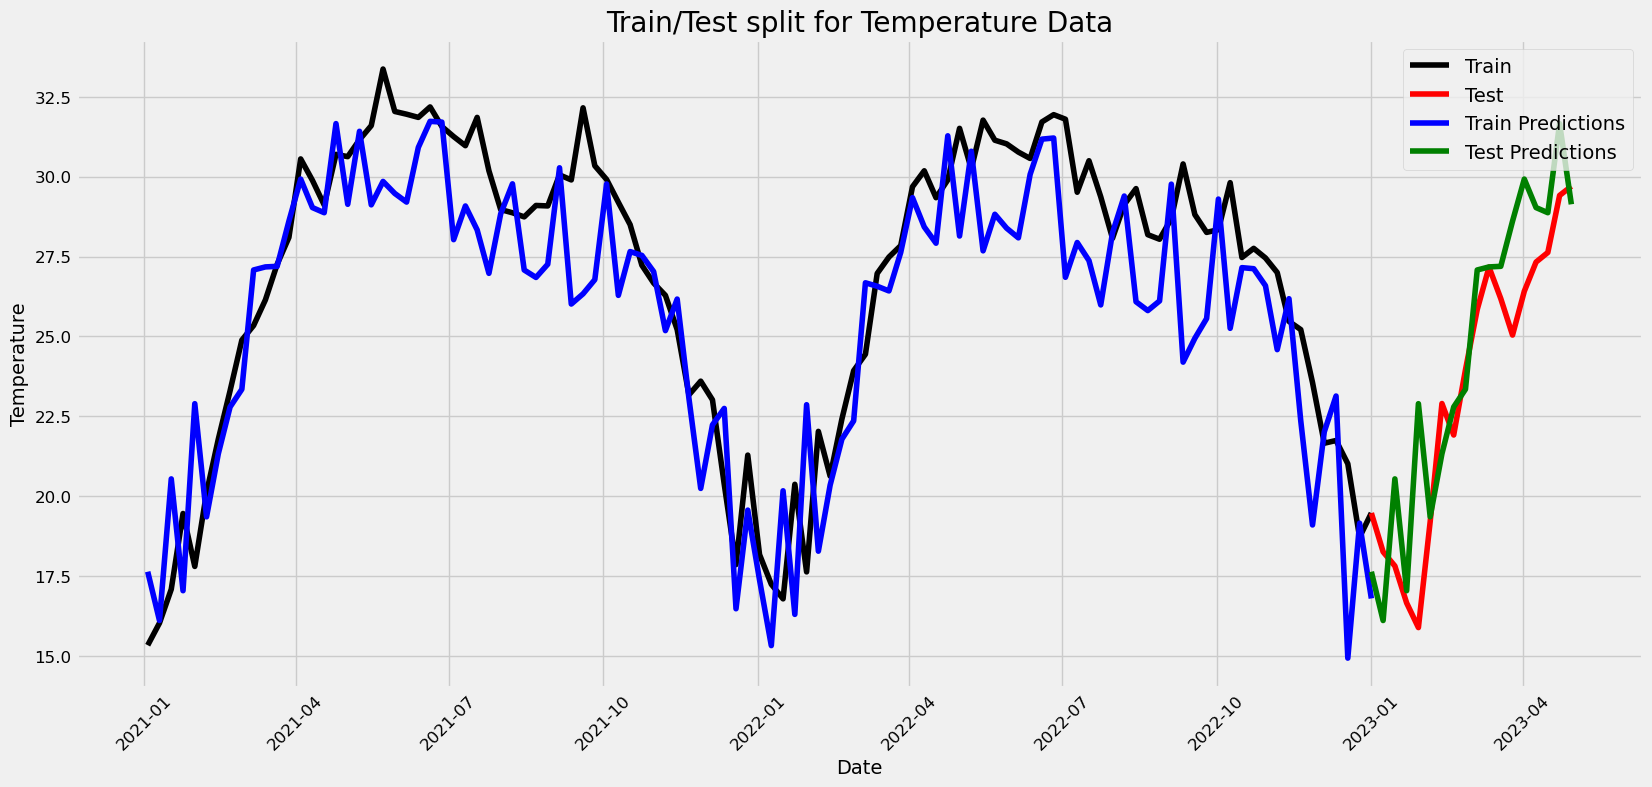

RMSE:  2.424172625200149


In [ ]:
# Use optimal parameters from above with lowest AIC

SARIMAXmodel = SARIMAX(train, order=(1,1,1),seasonal_order=(1, 1, 1, 52))
SARIMAXmodel = SARIMAXmodel.fit()

#Train set prediction
y_pred_train = SARIMAXmodel.get_forecast(len(train.index)) #only providing dates (train.index) from train as input for forecasting
y_pred_df_train = y_pred_train.conf_int(alpha = 0.05)
y_pred_df_train["Predictions"] = SARIMAXmodel.predict(start = y_pred_df_train.index[0], end = y_pred_df_train.index[-1])

#for training prediction plotting purposes
y_pred_df_train.index = train.index
y_pred_out_train = y_pred_df_train["Predictions"]

#Test set prediction
y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05)
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])

#for testing prediction plotting purposes
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"]

plt.plot(train, color = "black", label = 'Train')
plt.plot(test, color = "red", label = 'Test')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Temperature Data")

plt.plot(y_pred_out_train, color='blue', label = 'Train Predictions')

plt.plot(y_pred_out, color='green', label = 'Test Predictions')
plt.legend()
plt.show()

import numpy as np
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(test.values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

#### Comparison:

Comparing both ARIMA and SARIMA, we can see that ARIMA has RMSE: 2.676 while SARIMA has RMSE: 2.424 (with optimal parameters using grid search). When comparing the performance of the ARIMA and SARIMA models on the dataset, the SARIMA model clearly outperforms the ARIMA model. This is evident from the significantly lower RMSE of the SARIMA model, indicating more accurate predictions. The graphical representation supports this, showing that the SARIMA model’s predictions (represented by the green line) closely follow the actual test data (the red line), unlike the ARIMA model. Consequently, the SARIMA model is better suited for this temperature data and provides more precise temperature forecasts.

## Using Machine Learning Model

In [ ]:
train

datetime
2021-01-03    15.333333
2021-01-10    16.028571
2021-01-17    17.085714
2021-01-24    19.457143
2021-01-31    17.800000
                ...    
2022-12-04    21.657143
2022-12-11    21.742857
2022-12-18    21.014286
2022-12-25    18.714286
2023-01-01    19.471429
Freq: W-SUN, Name: temp, Length: 105, dtype: float64

In [ ]:
import numpy as np

#extract the seasonality data
months = [x.month for x in train.index]
years = [x.year for x in train.index]
day = [x.day for x in train.index]

#convert into one matrix
X = np.array([day, months, years]).T
Y = train.values

In [ ]:
X[:10]

array([[   3,    1, 2021],
       [  10,    1, 2021],
       [  17,    1, 2021],
       [  24,    1, 2021],
       [  31,    1, 2021],
       [   7,    2, 2021],
       [  14,    2, 2021],
       [  21,    2, 2021],
       [  28,    2, 2021],
       [   7,    3, 2021]])

In [ ]:
Y[:10]

array([15.33333333, 16.02857143, 17.08571429, 19.45714286, 17.8       ,
       20.11428571, 21.78571429, 23.3       , 24.88571429, 25.34285714])

In [ ]:
# extract the day, month and year data
tmonths = [x.month for x in test.index]
tyears = [x.year for x in test.index]
tday = [x.day for x in test.index]

# convert into one matrix
testX = np.array([tday, tmonths, tyears]).T
testY = test.values

In [ ]:
testX

array([[   1,    1, 2023],
       [   8,    1, 2023],
       [  15,    1, 2023],
       [  22,    1, 2023],
       [  29,    1, 2023],
       [   5,    2, 2023],
       [  12,    2, 2023],
       [  19,    2, 2023],
       [  26,    2, 2023],
       [   5,    3, 2023],
       [  12,    3, 2023],
       [  19,    3, 2023],
       [  26,    3, 2023],
       [   2,    4, 2023],
       [   9,    4, 2023],
       [  16,    4, 2023],
       [  23,    4, 2023],
       [  30,    4, 2023]])

In [ ]:
testY[:10]

array([19.47142857, 18.25714286, 17.81428571, 16.65714286, 15.88571429,
       19.2       , 22.9       , 21.91428571, 23.95714286, 25.84285714])

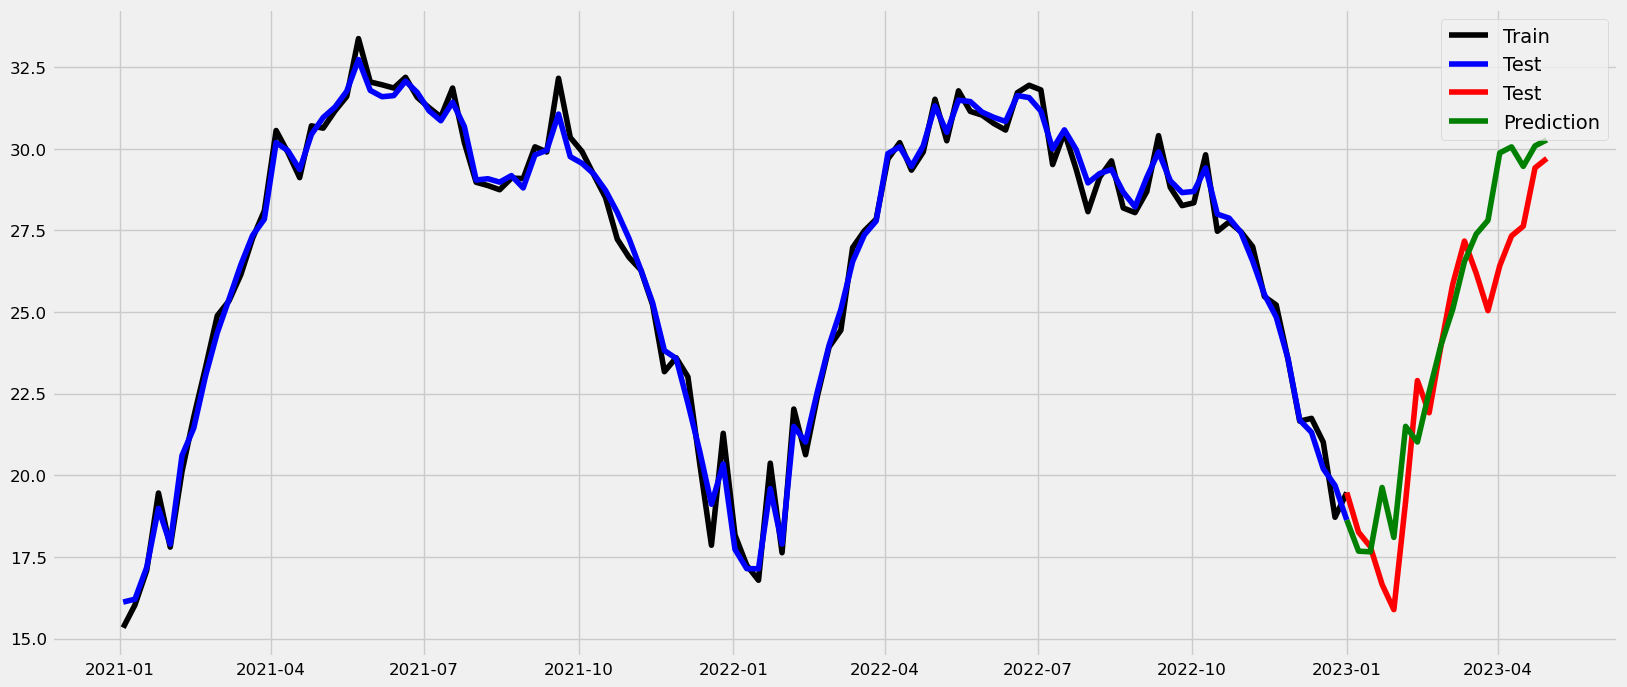

RMSE:  1.7887187598499892


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# fit the model
rfmodel = RandomForestRegressor()
rfmodel.fit(X,Y)

# predict for the test set period
preds_train = rfmodel.predict(X)

# predict for the test set period
preds = rfmodel.predict(testX)

# plot what has been learned
plt.plot(train.index.values, train.values,color="black", label='Train')
plt.plot(train.index.values, preds_train,color="blue", label='Test')
plt.plot(test.index.values, test.values,color="red", label='Test')
plt.plot(test.index.values, preds, color="green",label='Prediction')
plt.legend()
plt.show()
rf_rmse = np.sqrt(mean_squared_error(test.values, preds))
print("RMSE: ",rf_rmse)

#### Comparison:

In this scenario, the Random Forest regression model achieves the lowest RMSE value at 1.788, outperforming both SARIMA and ARIMA models. The SARIMA model registers an RMSE of 2.424, while ARIMA records the highest RMSE at 2.676, indicating the least accurate predictions among these models.

Considering the RMSE values for ARIMA, SARIMA, and Random Forest regression algorithms, it can be inferred that the Random Forest regressor performs the best among the techniques employed, with the lowest RMSE compared to the other two models. Additionally, visualized results demonstrate a strong alignment between predicted and test values across the entire dataset, making Random Forest a suitable fit for the weather dataset. Although SARIMA shows reasonable accuracy with a lower RMSE than ARIMA, the latter model performs the poorest, with a significantly higher RMSE and substantial deviations between predicted and test values.

Therefore, based on RMSE values, the Random Forest model emerges as the superior choice for this dataset, while the ARIMA model is the least effective. However, other factors like computational complexity and interpretability should also be considered when selecting the most suitable model for a specific use case.

## Forcasting future values

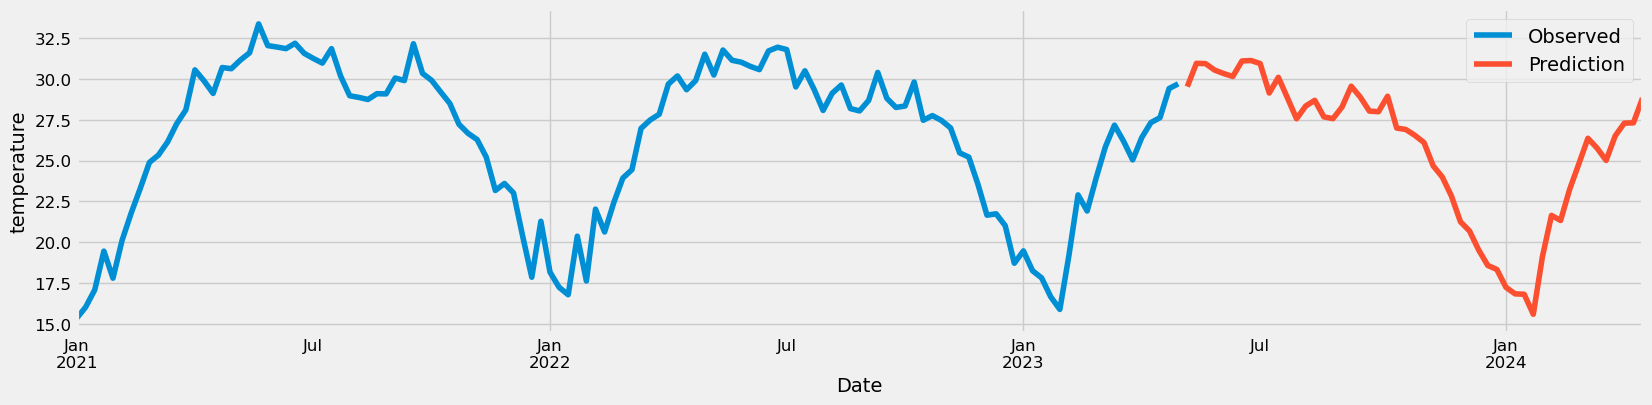

In [ ]:
start_date = '01/11/2024'
end_date = '31/12/2024'
future_dates = pd.date_range(start=start_date, end=end_date, freq='W')

train = weekly_df[weekly_df.index <= pd.to_datetime("2024-11-01", format='%Y-%m-%d')]

#Defining the SARIMA model with optimal parameters
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 52) # 52 weeks in a year
SARIMAXmodel = SARIMAX(train, order=order, seasonal_order=seasonal_order)

#Fitting the model to the training data
SARIMAXfit = SARIMAXmodel.fit()

#Generating predictions for the future dates
pred_u = SARIMAXfit.get_forecast(steps=len(future_dates))
pred_c = pred_u.conf_int()

#Plotting the observed data and the forecast
ax = train.plot(label='Observed', figsize=(18, 4))
pred_u.predicted_mean.plot(ax=ax, label='Prediction')
ax.set_xlabel('Date')
ax.set_ylabel('temperature')
plt.legend()
plt.show()

This graph illustrates the correlation between date and temperature for both observed and forecasted data. The red line in the graph represents the forecasted data, displaying a strikingly similar pattern to the blue line, which represents the observed data. This graph serves as the basis for the forecasted data.

In [ ]:
pred_mean = pred_u.predicted_mean
forecast_da = pd.DataFrame({'date': future_dates, 'temp_Pre': pred_mean.values,})

#Setting the index to the date column
forecast_da.set_index('date', inplace=True)
Res = forecast_da[forecast_da.index >= pd.to_datetime("2024-11-01", format='%Y-%m-%d')]
Res

,temp_Pre
date,
2024-11-03,23.249535
2024-11-10,24.795095
2024-11-17,26.366602
2024-11-24,25.769462
2024-12-01,25.011664
2024-12-08,26.518308
2024-12-15,27.294343
2024-12-22,27.314543
2024-12-29,28.828743


In [ ]:
# Extracting the seasonality data
months = [x.month for x in train.index]
years = [x.year for x in train.index]
day = [x.day for x in train.index]

# Converting into one matrix
trainX2 = np.array([day, months, years]).T
trainY2 = train.values

# Extract the day, month and year data
tmonths = [x.month for x in test.index]
tyears = [x.year for x in test.index]
tday = [x.day for x in test.index]

# Convert into one matrix
testX2 = np.array([tday, tmonths, tyears]).T
testY2 = test.values

In [ ]:
#Random Forest Regression Model

rfmodel = RandomForestRegressor()
rfmodel.fit(trainX2,trainY2)

pred = rfmodel.predict(testX2)
pred = pd.Series(pred)
pred

0     18.783619
1     17.834429
2     17.467571
3     17.491286
4     16.637143
5     20.200857
6     22.145286
7     22.242429
8     23.943857
9     25.607429
10    26.799143
11    26.344286
12    26.099000
13    27.119857
14    27.631714
15    27.811714
16    28.956571
17    29.389429
dtype: float64

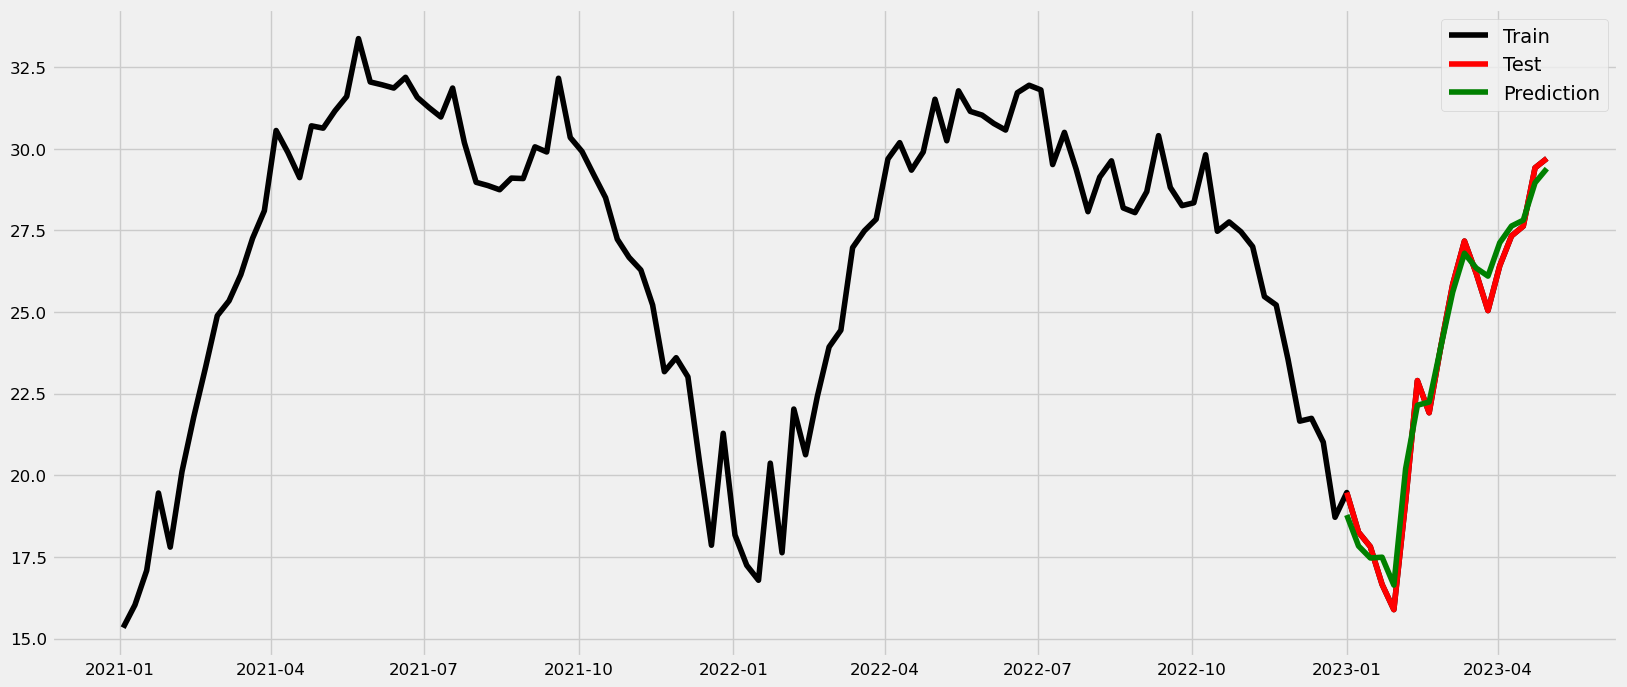

RMSE:  1.7887187598499892


In [ ]:
plt.plot(train.index, train.values,color="black", label='Train')
plt.plot(test.index, test.values,color="red", label='Test')
plt.plot(test.index, pred, color="green",label='Prediction')
plt.legend()
plt.show()

rf_rmse = np.sqrt(mean_squared_error(test.values, preds))
print("RMSE: ",rf_rmse)

The root mean square error (RMSE) of 1.788 indicates a difference of about 1.78 units between predicted and forecasted values. This difference is slightly lower than the RMSE observed when using the Random Forest Regressor on the previous test dataset from the original dataset. Therefore, it can be deduced that although the Random Forest Regressor performed well on the original dataset, its effectiveness may be slightly enhanced when applied to the forecasted dataset.